In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import os, datetime
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [81]:
def get_file_names(folder):
    #Listing entries present in given folder
    entries = os.listdir(folder)
    for i in entries:
        if 'csv' not in i:
            entries.remove(i)
    return sorted(entries, reverse=True)[0:12]

train_path = "../split_datasets/train/"
test_path = "../split_datasets/test/"
val_path = "../split_datasets/validation/"

train_files = get_file_names(train_path)
test_files = get_file_names(test_path)
val_files = get_file_names(val_path)

frames = []
for i in train_files:
    frames.append(pd.read_csv(train_path+i)[0:100])
    break
train_df = pd.concat(frames, sort=False)
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.fillna(0)

frames = []
for i in test_files:
    frames.append(pd.read_csv(test_path+i))
    break
test_df = pd.concat(frames, sort=False)
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.fillna(0)

frames = []
for i in val_files:
    frames.append(pd.read_csv(val_path+i)[0:100])
    break
val_df = pd.concat(frames, sort=False)
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.fillna(0)

min_price = min(train_df['price'].min(), test_df['price'].min(), val_df['price'].min())
max_price = max(train_df['price'].max(), test_df['price'].max(), val_df['price'].max())
#min_long = min(train_df['longitude'].min(), test_df['longitude'].min(), val_df['longitude'].min())
#max_long = max(train_df['longitude'].max(), test_df['longitude'].max(), val_df['longitude'].max())
min_lat = min(train_df['latitude'].min(), test_df['latitude'].min(), val_df['latitude'].min())
max_lat = max(train_df['latitude'].max(), test_df['latitude'].max(), val_df['latitude'].max())

train_df['price'] = (train_df['price'] - min_price)/(max_price - min_price)
#train_df['longitude'] = (train_df['longitude'] - min_long)/(max_long - min_long)
train_df['latitude'] = (train_df['latitude'] - min_lat)/(max_lat - min_lat)
train_df = train_df.reset_index(drop=True)

test_df['price'] = (test_df['price'] - min_price)/(max_price - min_price)
#test_df['longitude'] = (test_df['longitude'] - min_long)/(max_long - min_long)
test_df['latitude'] = (test_df['latitude'] - min_lat)/(max_lat - min_lat)
test_df = test_df.reset_index(drop=True)

val_df['price'] = (val_df['price'] - min_price)/(max_price - min_price)
#val_df['longitude'] = (val_df['longitude'] - min_long)/(max_long - min_long)
val_df['latitude'] = (val_df['latitude'] - min_lat)/(max_lat - min_lat)
val_df = val_df.reset_index(drop=True)
#train_df = train_df.drop(columns=["minimum_nights", "maximum_nights"])
#test_df = test_df.drop(columns=["minimum_nights", "maximum_nights"])
#val_df = val_df.drop(columns=["minimum_nights", "maximum_nights"])

print(minimum, maximum)
bounds = [min_price, max_price]

36 349


In [82]:
train_df.head(5)

latitude  accommodates  bathrooms  bedrooms  beds     price  amenities_TV  \
0  0.295877             2        1.0       0.0   2.0  0.047923             1   
1  0.308621             2        1.0       1.0   2.0  0.348243             0   
2  0.441983             3        1.0       1.0   2.0  0.303514             1   
3  0.730529             2        1.0       1.0   1.0  0.204473             1   
4  0.268638             4        1.5       1.0   1.0  0.316294             1   

   amenities_Air conditioning  amenities_Kitchen  amenities_Indoor fireplace  \
0                           1                  1                           0   
1                           0                  1                           0   
2                           1                  1                           1   
3                           1                  1                           0   
4                           1                  1                           0   

   ...  property_type_House  property_type_Loft  \
0  ...                    0                   1   
1  ...                    0                   0   
2  ...                    0                   0   
3  ...                    1                   0   
4  ...                    0                   0   

   property_type_Serviced apartment  room_type_Entire home/apt  \
0                                 0                          1   
1                                 0                          0   
2                                 0                          1   
3                                 0                          1   
4                                 0                          1   

   room_type_Private room  room_type_Shared room  instant_bookable_f  \
0                       0                      0                   1   
1                       1                      0                   1   
2                       0                      0                   1   
3                       0                      0                   0   
4                       0                      0                   1   

   instant_bookable_t  cancellation_policy_flexible  \
0                   0                             1   
1                   0                             0   
2                   0                             1   
3                   1                             1   
4                   0                             0   

   cancellation_policy_strict_14_with_grace_period  
0                                                0  
1                                                1  
2                                                0  
3                                                0  
4                                                0  

[5 rows x 67 columns]

In [83]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.df = df
        self.price = self.df["price"]
        self.df = self.df.drop(columns="price")
        self.purpose = purpose
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = torch.tensor(self.df.iloc[index]).float()
        label = torch.tensor([self.price.iloc[index]]).float()
        return {"sample": sample, "label": label}

In [84]:
train_ds = airbnb_dataset(train_df, "train")
test_ds = airbnb_dataset(test_df, "test")
val_ds = airbnb_dataset(val_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=False, num_workers=0)

In [85]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(66, 132)
        self.layer2 = nn.Linear(132, 132)
        self.layer3 = nn.Linear(132, 66)
        self.layer4 = nn.Linear(66, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        return self.layer4(x)

In [90]:
def train(net, train_loader, val_loader, bounds, folder):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01, momentum = 0.9)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    epochs2, train_error, val_error, train_acc, val_acc = [], [], [], [[],[],[]], [[],[],[]]
    
    for epoch in range(1000):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        for i, data in enumerate(train_loader):
            sample = data["sample"]
            label = data["label"]
            output = net(sample)
            loss = criterion(output, label)
            #print(label, output)
            #print(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss.item()
            epoch_loss += loss.item()
            if i % 10 == 9:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i+1, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        # Record Loss
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        # Record Error, Accuracy 
        if epoch % 10 == 9:
            epochs2.append(epoch)
            avg_train_error, avg_train_acc, avg_val_error, avg_val_acc = get_error(net, train_loader, val_loader, [10, 20, 30], bounds)
            train_error.append(avg_train_error)
            val_error.append(avg_val_error)
            for i in range(3):
                train_acc[i].append(avg_train_acc[i])
                val_acc[i].append(avg_val_acc[i])
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 10 == 9:
            plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=False)

    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
    # plot loss, error, accuracy
    plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=True)
    

def plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=False):
    # plot loss curve
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    if last == False:
        plt.savefig(folder+"/lossplot/lossplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/lossplot_final.png", dpi=150)
    plt.close()
    
    # plot error curve
    plt.title("Training Error Curve")
    plt.plot(epochs2, train_error, label="Train")
    plt.plot(epochs2, val_error, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Absolute Error (in $)")
    plt.legend(loc='best')
    plt.show()
    if last == False:
        plt.savefig(folder+"/errorplot/errorplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/errorplot_final.png", dpi=150)
    plt.close()

    # plot accuracy curve
    plt.title("Training Accuracy Curve")
    for i in range(3):
        plt.plot(epochs2, train_acc[i], label="Train - Thresh: "+str(i*10+10))
        plt.plot(epochs2, val_acc[i], label="Validation - Thresh: "+str(i*10+10))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    if last == False:
        plt.savefig(folder+"/accplot/accplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/accplot_final.png", dpi=150)
    plt.close()
    
    return None

In [87]:
def get_error(model, train_loader, val_loader, threshold, bounds):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    for i, data in enumerate(train_loader):
        sample = data["sample"]
        label = data["label"]
        output = net(sample)
        error = abs(label-output)
        for j in range(len(threshold)):
            accurate = (error < float(threshold[j])/float(bounds[1]-bounds[0]))
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)*(bounds[1]-bounds[0])
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    val_samples = 0
    val_error = 0
    val_accuracy = [0 for i in threshold]
    for i, data in enumerate(val_loader):
        sample = data["sample"]
        label = data["label"]
        output = net(sample)
        error = abs(label-output)
        for j in range(len(threshold)):
            accurate = (error < float(threshold[j])/float(bounds[1]-bounds[0]))
            val_accuracy[j] += accurate.sum().item()
        val_samples += len(label)
        val_error += error.sum().item()
    avg_val_error = float(val_error)/float(val_samples)*(bounds[1]-bounds[0])
    avg_val_accuracy = [float(a)/float(val_samples) for a in val_accuracy]

    return avg_train_error, avg_train_accuracy, avg_val_error, avg_val_accuracy

In [91]:
net = airbnb_net()

Starting Training...
[EPOCH 1] loss: 0.072345  time: 0.153
[EPOCH 2] loss: 0.068821  time: 0.115
[EPOCH 3] loss: 0.062714  time: 0.120
[EPOCH 4] loss: 0.055188  time: 0.098
[EPOCH 5] loss: 0.047403  time: 0.106
[EPOCH 6] loss: 0.040362  time: 0.097
[EPOCH 7] loss: 0.034657  time: 0.114
[EPOCH 8] loss: 0.030664  time: 0.114
[EPOCH 9] loss: 0.028314  time: 0.117
[EPOCH 10] loss: 0.027406  time: 0.341


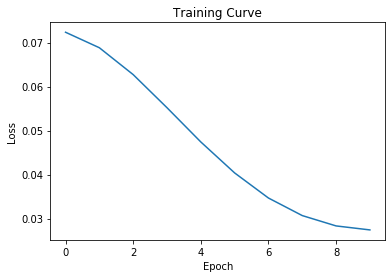

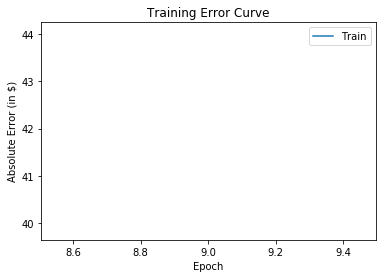

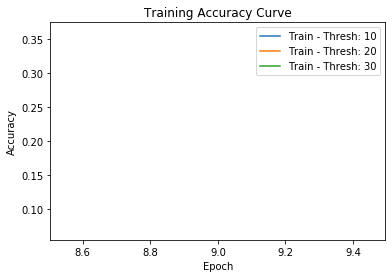

[EPOCH 11] loss: 0.027595  time: 0.091
[EPOCH 12] loss: 0.028489  time: 0.098
[EPOCH 13] loss: 0.029730  time: 0.149
[EPOCH 14] loss: 0.030992  time: 0.128
[EPOCH 15] loss: 0.032018  time: 0.199
[EPOCH 16] loss: 0.032647  time: 0.145
[EPOCH 17] loss: 0.032800  time: 0.205
[EPOCH 18] loss: 0.032481  time: 0.154
[EPOCH 19] loss: 0.031762  time: 0.156
[EPOCH 20] loss: 0.030754  time: 0.421


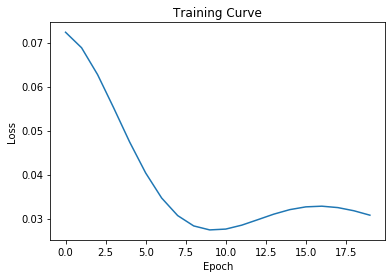

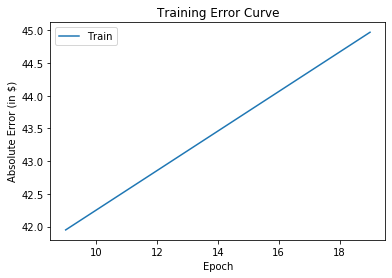

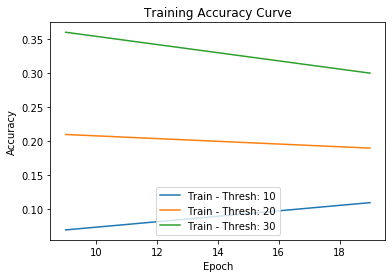

[EPOCH 21] loss: 0.029588  time: 0.080
[EPOCH 22] loss: 0.028393  time: 0.130
[EPOCH 23] loss: 0.027276  time: 0.107
[EPOCH 24] loss: 0.026313  time: 0.136
[EPOCH 25] loss: 0.025550  time: 0.119
[EPOCH 26] loss: 0.025000  time: 0.124
[EPOCH 27] loss: 0.024647  time: 0.103
[EPOCH 28] loss: 0.024457  time: 0.124
[EPOCH 29] loss: 0.024383  time: 0.132
[EPOCH 30] loss: 0.024373  time: 0.358


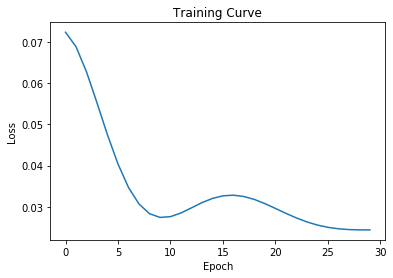

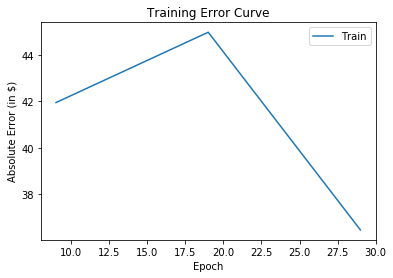

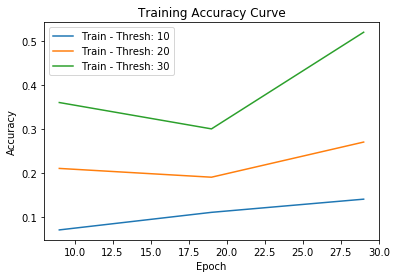

[EPOCH 31] loss: 0.024378  time: 0.080
[EPOCH 32] loss: 0.024359  time: 0.105
[EPOCH 33] loss: 0.024283  time: 0.126
[EPOCH 34] loss: 0.024137  time: 0.112
[EPOCH 35] loss: 0.023919  time: 0.094
[EPOCH 36] loss: 0.023640  time: 0.130
[EPOCH 37] loss: 0.023315  time: 0.107
[EPOCH 38] loss: 0.022960  time: 0.095
[EPOCH 39] loss: 0.022595  time: 0.117
[EPOCH 40] loss: 0.022241  time: 0.353


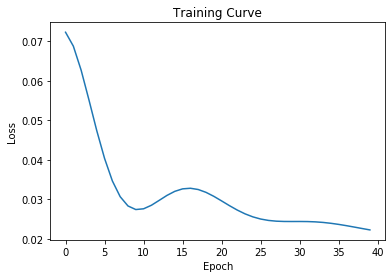

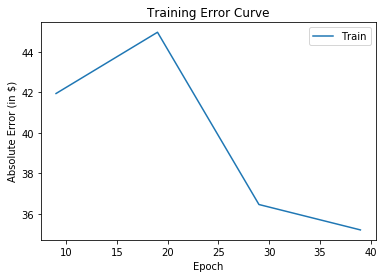

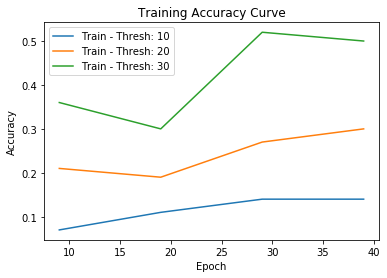

[EPOCH 41] loss: 0.021910  time: 0.099
[EPOCH 42] loss: 0.021615  time: 0.119
[EPOCH 43] loss: 0.021361  time: 0.120
[EPOCH 44] loss: 0.021146  time: 0.126
[EPOCH 45] loss: 0.020965  time: 0.123
[EPOCH 46] loss: 0.020809  time: 0.129
[EPOCH 47] loss: 0.020664  time: 0.113
[EPOCH 48] loss: 0.020519  time: 0.120
[EPOCH 49] loss: 0.020366  time: 0.114
[EPOCH 50] loss: 0.020200  time: 0.349


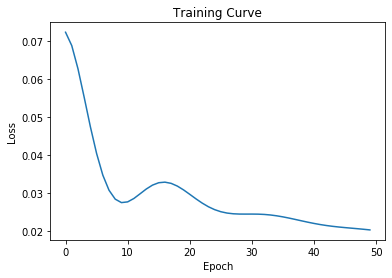

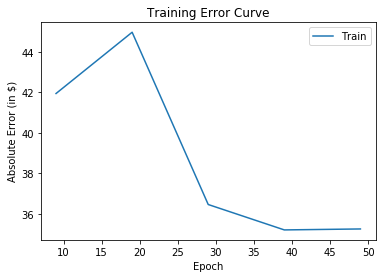

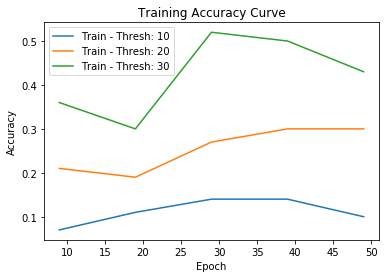

[EPOCH 51] loss: 0.020018  time: 0.081
[EPOCH 52] loss: 0.019819  time: 0.097
[EPOCH 53] loss: 0.019606  time: 0.106
[EPOCH 54] loss: 0.019385  time: 0.129
[EPOCH 55] loss: 0.019161  time: 0.120
[EPOCH 56] loss: 0.018937  time: 0.112
[EPOCH 57] loss: 0.018719  time: 0.124
[EPOCH 58] loss: 0.018511  time: 0.131
[EPOCH 59] loss: 0.018314  time: 0.149
[EPOCH 60] loss: 0.018126  time: 0.361


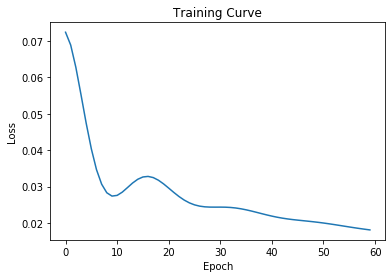

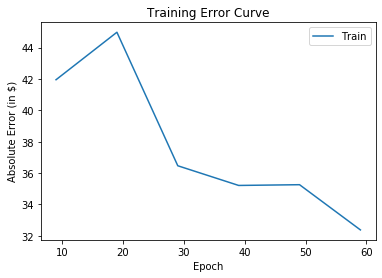

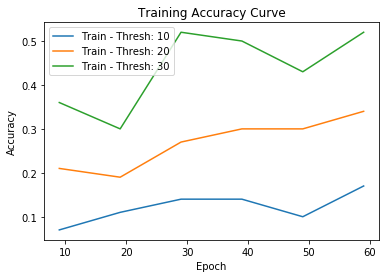

[EPOCH 61] loss: 0.017945  time: 0.153
[EPOCH 62] loss: 0.017770  time: 0.207
[EPOCH 63] loss: 0.017599  time: 0.143
[EPOCH 64] loss: 0.017428  time: 0.165
[EPOCH 65] loss: 0.017257  time: 0.182
[EPOCH 66] loss: 0.017083  time: 0.134
[EPOCH 67] loss: 0.016907  time: 0.135
[EPOCH 68] loss: 0.016730  time: 0.151
[EPOCH 69] loss: 0.016552  time: 0.125
[EPOCH 70] loss: 0.016376  time: 0.378


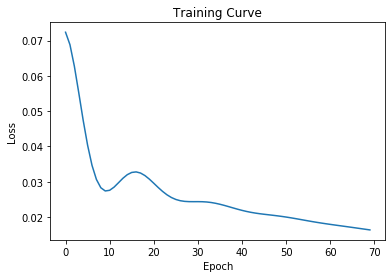

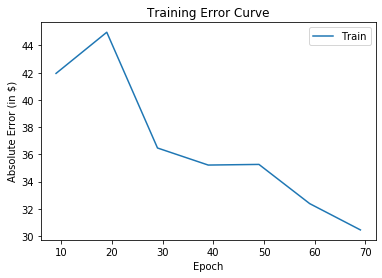

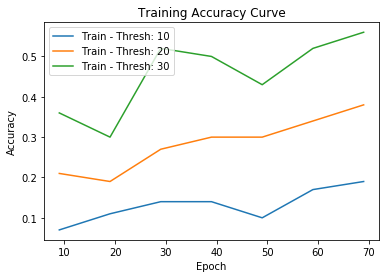

[EPOCH 71] loss: 0.016202  time: 0.118
[EPOCH 72] loss: 0.016032  time: 0.139
[EPOCH 73] loss: 0.015868  time: 0.164
[EPOCH 74] loss: 0.015709  time: 0.093
[EPOCH 75] loss: 0.015555  time: 0.100
[EPOCH 76] loss: 0.015403  time: 0.129
[EPOCH 77] loss: 0.015257  time: 0.129
[EPOCH 78] loss: 0.015115  time: 0.137
[EPOCH 79] loss: 0.014975  time: 0.111
[EPOCH 80] loss: 0.014838  time: 0.392


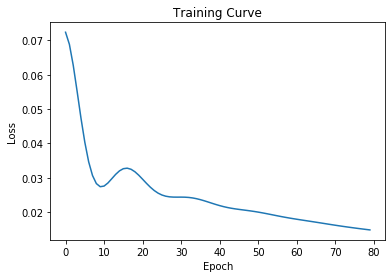

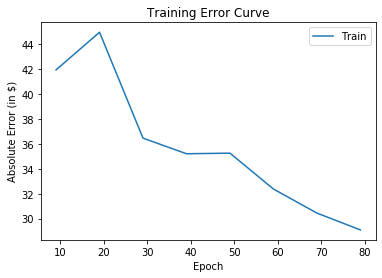

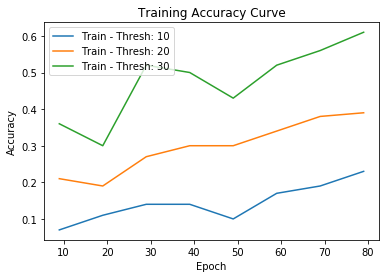

[EPOCH 81] loss: 0.014701  time: 0.114
[EPOCH 82] loss: 0.014565  time: 0.163
[EPOCH 83] loss: 0.014432  time: 0.159
[EPOCH 84] loss: 0.014301  time: 0.142
[EPOCH 85] loss: 0.014173  time: 0.160
[EPOCH 86] loss: 0.014047  time: 0.131
[EPOCH 87] loss: 0.013925  time: 0.128
[EPOCH 88] loss: 0.013805  time: 0.106
[EPOCH 89] loss: 0.013689  time: 0.102
[EPOCH 90] loss: 0.013575  time: 0.472


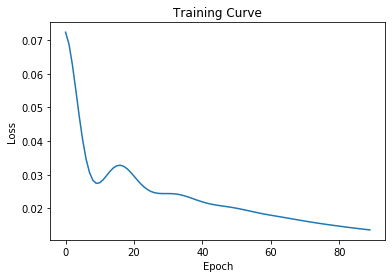

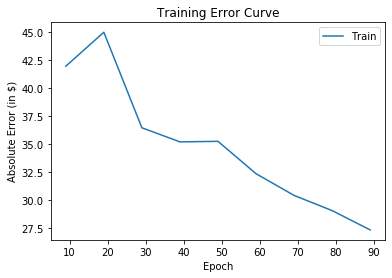

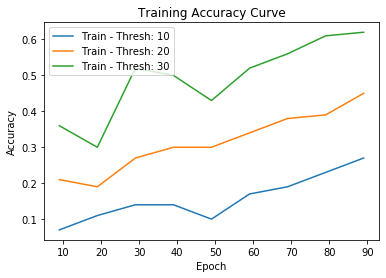

[EPOCH 91] loss: 0.013463  time: 0.122
[EPOCH 92] loss: 0.013355  time: 0.120
[EPOCH 93] loss: 0.013250  time: 0.134
[EPOCH 94] loss: 0.013147  time: 0.115
[EPOCH 95] loss: 0.013046  time: 0.116
[EPOCH 96] loss: 0.012948  time: 0.129
[EPOCH 97] loss: 0.012853  time: 0.124
[EPOCH 98] loss: 0.012759  time: 0.124
[EPOCH 99] loss: 0.012668  time: 0.119
[EPOCH 100] loss: 0.012579  time: 0.369


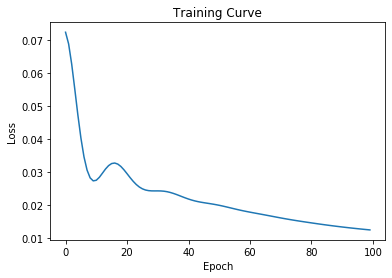

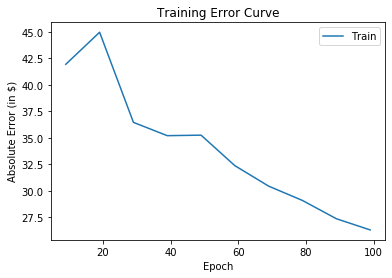

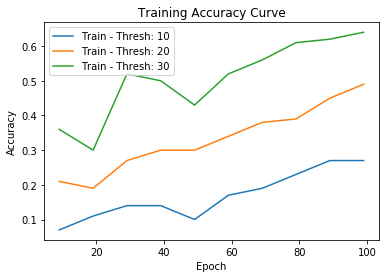

[EPOCH 101] loss: 0.012493  time: 0.083
[EPOCH 102] loss: 0.012408  time: 0.095
[EPOCH 103] loss: 0.012327  time: 0.106
[EPOCH 104] loss: 0.012247  time: 0.116
[EPOCH 105] loss: 0.012169  time: 0.096
[EPOCH 106] loss: 0.012093  time: 0.122
[EPOCH 107] loss: 0.012019  time: 0.119
[EPOCH 108] loss: 0.011946  time: 0.117
[EPOCH 109] loss: 0.011875  time: 0.122
[EPOCH 110] loss: 0.011806  time: 0.339


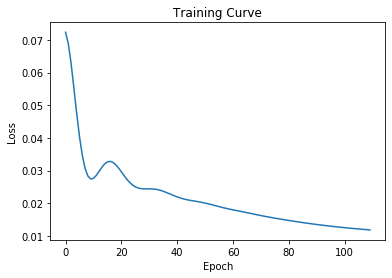

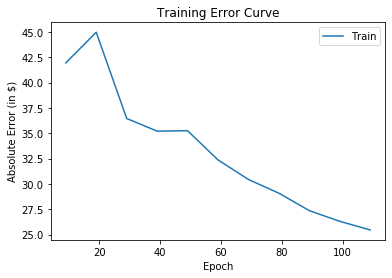

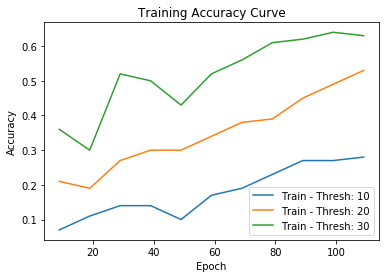

[EPOCH 111] loss: 0.011740  time: 0.089
[EPOCH 112] loss: 0.011675  time: 0.107
[EPOCH 113] loss: 0.011612  time: 0.104
[EPOCH 114] loss: 0.011550  time: 0.106
[EPOCH 115] loss: 0.011491  time: 0.097
[EPOCH 116] loss: 0.011434  time: 0.101
[EPOCH 117] loss: 0.011378  time: 0.099
[EPOCH 118] loss: 0.011322  time: 0.104
[EPOCH 119] loss: 0.011268  time: 0.099
[EPOCH 120] loss: 0.011214  time: 0.284


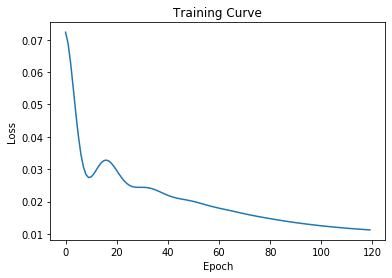

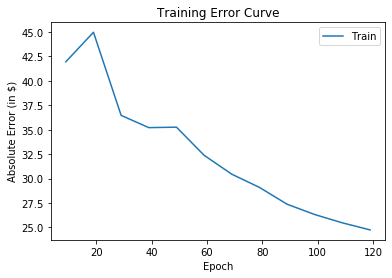

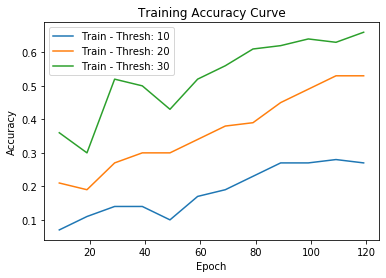

[EPOCH 121] loss: 0.011162  time: 0.091
[EPOCH 122] loss: 0.011110  time: 0.086
[EPOCH 123] loss: 0.011059  time: 0.085
[EPOCH 124] loss: 0.011010  time: 0.099
[EPOCH 125] loss: 0.010961  time: 0.093
[EPOCH 126] loss: 0.010914  time: 0.090
[EPOCH 127] loss: 0.010867  time: 0.101
[EPOCH 128] loss: 0.010821  time: 0.100
[EPOCH 129] loss: 0.010776  time: 0.089
[EPOCH 130] loss: 0.010732  time: 0.293


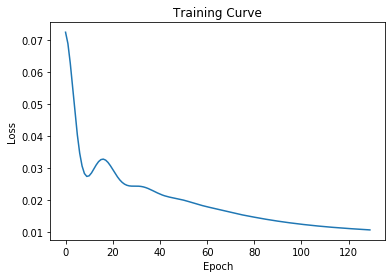

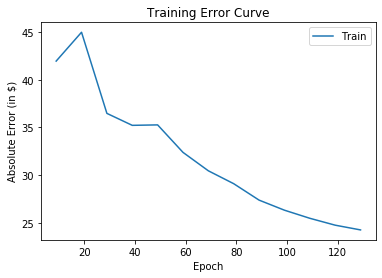

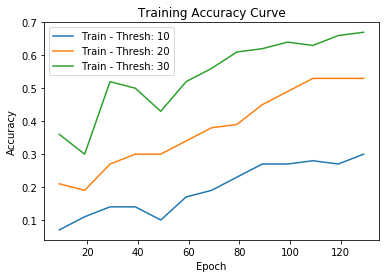

[EPOCH 131] loss: 0.010688  time: 0.082
[EPOCH 132] loss: 0.010646  time: 0.094
[EPOCH 133] loss: 0.010604  time: 0.100
[EPOCH 134] loss: 0.010562  time: 0.099
[EPOCH 135] loss: 0.010521  time: 0.106
[EPOCH 136] loss: 0.010480  time: 0.087
[EPOCH 137] loss: 0.010440  time: 0.100
[EPOCH 138] loss: 0.010401  time: 0.100
[EPOCH 139] loss: 0.010362  time: 0.099
[EPOCH 140] loss: 0.010323  time: 0.310


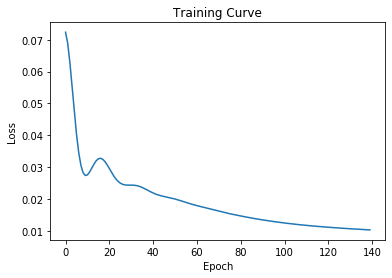

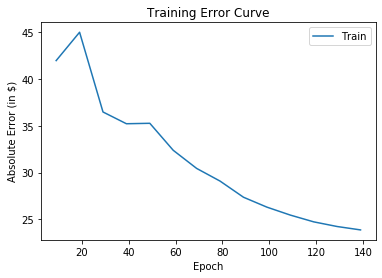

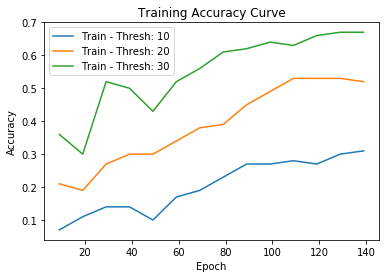

[EPOCH 141] loss: 0.010285  time: 0.075
[EPOCH 142] loss: 0.010248  time: 0.092
[EPOCH 143] loss: 0.010211  time: 0.088
[EPOCH 144] loss: 0.010173  time: 0.108
[EPOCH 145] loss: 0.010137  time: 0.093
[EPOCH 146] loss: 0.010100  time: 0.095
[EPOCH 147] loss: 0.010064  time: 0.095
[EPOCH 148] loss: 0.010029  time: 0.098
[EPOCH 149] loss: 0.009994  time: 0.104
[EPOCH 150] loss: 0.009960  time: 0.287


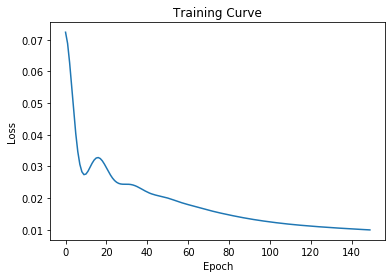

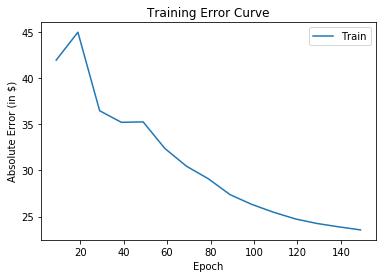

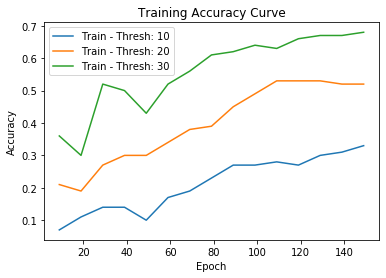

[EPOCH 151] loss: 0.009926  time: 0.078
[EPOCH 152] loss: 0.009893  time: 0.086
[EPOCH 153] loss: 0.009860  time: 0.096
[EPOCH 154] loss: 0.009827  time: 0.102
[EPOCH 155] loss: 0.009795  time: 0.096
[EPOCH 156] loss: 0.009763  time: 0.095
[EPOCH 157] loss: 0.009731  time: 0.099
[EPOCH 158] loss: 0.009699  time: 0.095
[EPOCH 159] loss: 0.009668  time: 0.098
[EPOCH 160] loss: 0.009637  time: 0.282


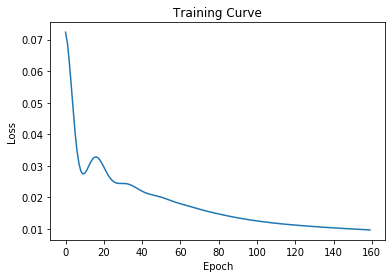

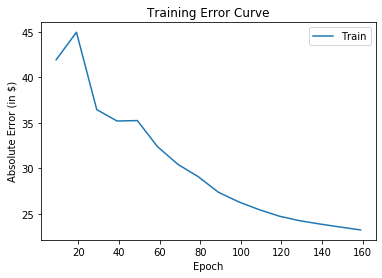

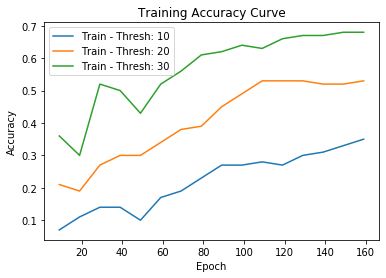

[EPOCH 161] loss: 0.009607  time: 0.076
[EPOCH 162] loss: 0.009577  time: 0.095
[EPOCH 163] loss: 0.009547  time: 0.095
[EPOCH 164] loss: 0.009517  time: 0.105
[EPOCH 165] loss: 0.009487  time: 0.102
[EPOCH 166] loss: 0.009457  time: 0.101
[EPOCH 167] loss: 0.009428  time: 0.103
[EPOCH 168] loss: 0.009399  time: 0.094
[EPOCH 169] loss: 0.009371  time: 0.101
[EPOCH 170] loss: 0.009343  time: 0.282


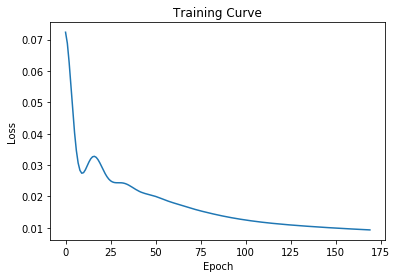

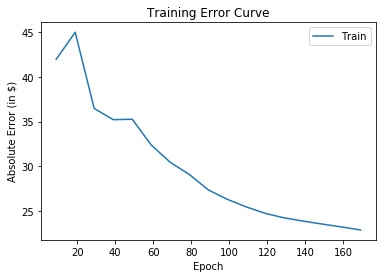

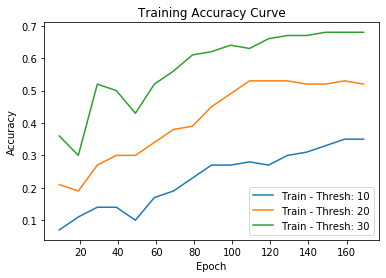

[EPOCH 171] loss: 0.009315  time: 0.080
[EPOCH 172] loss: 0.009287  time: 0.096
[EPOCH 173] loss: 0.009260  time: 0.101
[EPOCH 174] loss: 0.009233  time: 0.096
[EPOCH 175] loss: 0.009206  time: 0.089
[EPOCH 176] loss: 0.009179  time: 0.102
[EPOCH 177] loss: 0.009153  time: 0.102
[EPOCH 178] loss: 0.009126  time: 0.096
[EPOCH 179] loss: 0.009100  time: 0.098
[EPOCH 180] loss: 0.009073  time: 0.301


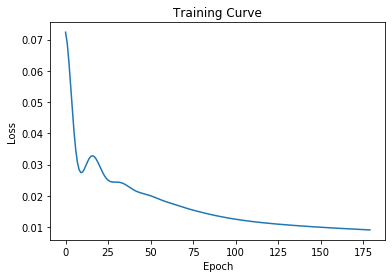

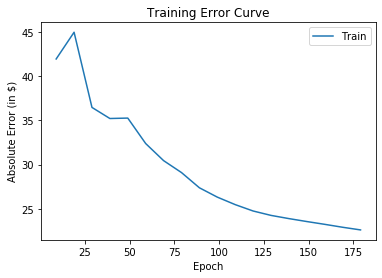

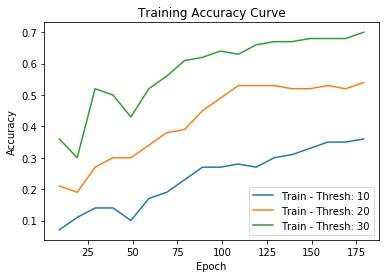

[EPOCH 181] loss: 0.009047  time: 0.077
[EPOCH 182] loss: 0.009021  time: 0.090
[EPOCH 183] loss: 0.008995  time: 0.091
[EPOCH 184] loss: 0.008969  time: 0.107
[EPOCH 185] loss: 0.008943  time: 0.098
[EPOCH 186] loss: 0.008917  time: 0.097
[EPOCH 187] loss: 0.008891  time: 0.099
[EPOCH 188] loss: 0.008865  time: 0.097
[EPOCH 189] loss: 0.008839  time: 0.096
[EPOCH 190] loss: 0.008813  time: 0.292


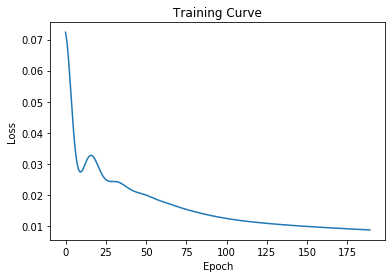

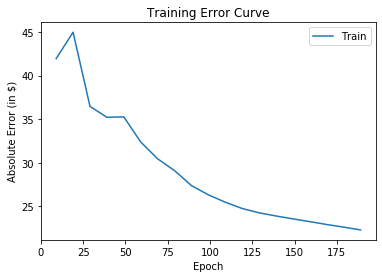

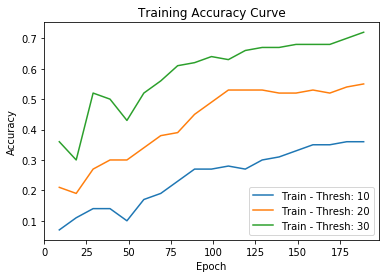

[EPOCH 191] loss: 0.008786  time: 0.077
[EPOCH 192] loss: 0.008760  time: 0.091
[EPOCH 193] loss: 0.008734  time: 0.099
[EPOCH 194] loss: 0.008708  time: 0.100
[EPOCH 195] loss: 0.008682  time: 0.095
[EPOCH 196] loss: 0.008656  time: 0.097
[EPOCH 197] loss: 0.008630  time: 0.102
[EPOCH 198] loss: 0.008605  time: 0.102
[EPOCH 199] loss: 0.008579  time: 0.094
[EPOCH 200] loss: 0.008553  time: 0.294


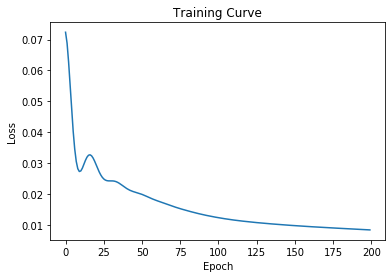

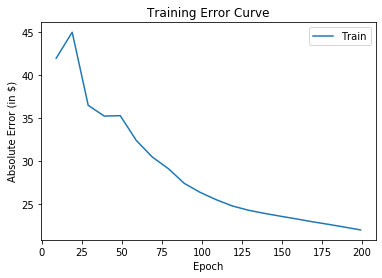

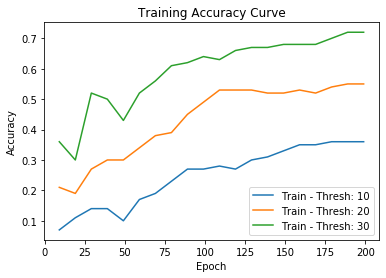

[EPOCH 201] loss: 0.008527  time: 0.076
[EPOCH 202] loss: 0.008501  time: 0.094
[EPOCH 203] loss: 0.008476  time: 0.097
[EPOCH 204] loss: 0.008450  time: 0.097
[EPOCH 205] loss: 0.008425  time: 0.094
[EPOCH 206] loss: 0.008400  time: 0.092
[EPOCH 207] loss: 0.008375  time: 0.103
[EPOCH 208] loss: 0.008349  time: 0.100
[EPOCH 209] loss: 0.008324  time: 0.098
[EPOCH 210] loss: 0.008299  time: 0.297


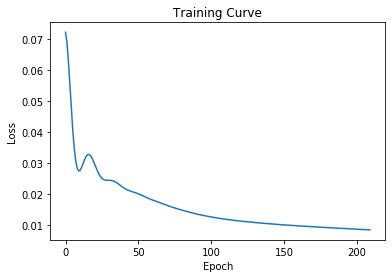

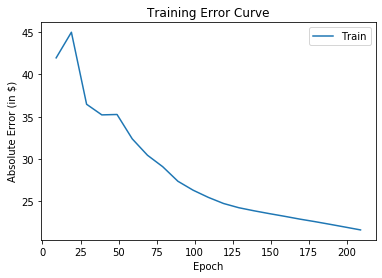

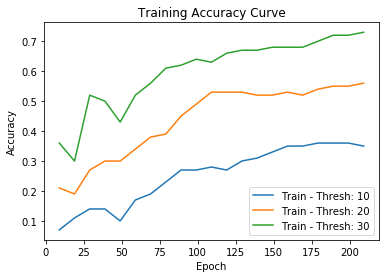

[EPOCH 211] loss: 0.008274  time: 0.103
[EPOCH 212] loss: 0.008250  time: 0.107
[EPOCH 213] loss: 0.008225  time: 0.105
[EPOCH 214] loss: 0.008200  time: 0.099
[EPOCH 215] loss: 0.008175  time: 0.097
[EPOCH 216] loss: 0.008151  time: 0.096
[EPOCH 217] loss: 0.008126  time: 0.098
[EPOCH 218] loss: 0.008102  time: 0.092
[EPOCH 219] loss: 0.008077  time: 0.104
[EPOCH 220] loss: 0.008053  time: 0.299


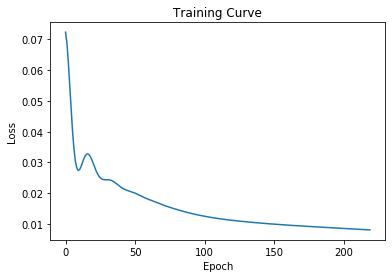

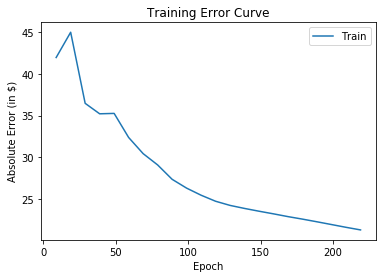

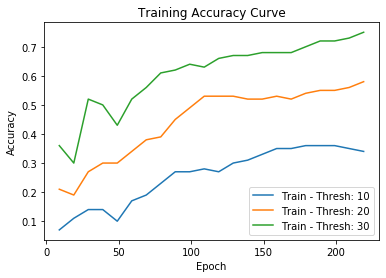

[EPOCH 221] loss: 0.008029  time: 0.075
[EPOCH 222] loss: 0.008004  time: 0.096
[EPOCH 223] loss: 0.007980  time: 0.088
[EPOCH 224] loss: 0.007956  time: 0.098
[EPOCH 225] loss: 0.007932  time: 0.104
[EPOCH 226] loss: 0.007908  time: 0.097
[EPOCH 227] loss: 0.007884  time: 0.101
[EPOCH 228] loss: 0.007860  time: 0.098
[EPOCH 229] loss: 0.007836  time: 0.099
[EPOCH 230] loss: 0.007812  time: 0.294


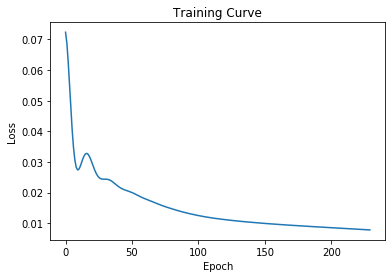

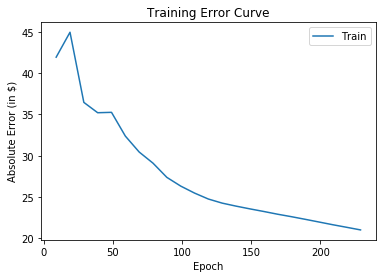

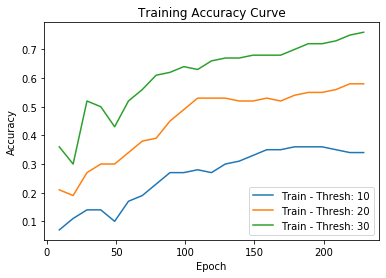

[EPOCH 231] loss: 0.007788  time: 0.077
[EPOCH 232] loss: 0.007764  time: 0.103
[EPOCH 233] loss: 0.007741  time: 0.097
[EPOCH 234] loss: 0.007717  time: 0.098
[EPOCH 235] loss: 0.007693  time: 0.101
[EPOCH 236] loss: 0.007670  time: 0.092
[EPOCH 237] loss: 0.007646  time: 0.099
[EPOCH 238] loss: 0.007623  time: 0.128
[EPOCH 239] loss: 0.007600  time: 0.098
[EPOCH 240] loss: 0.007577  time: 0.303


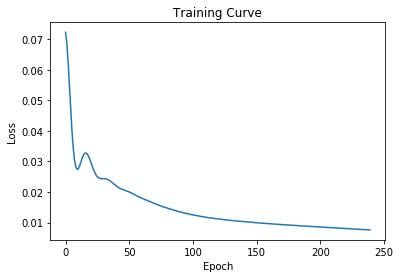

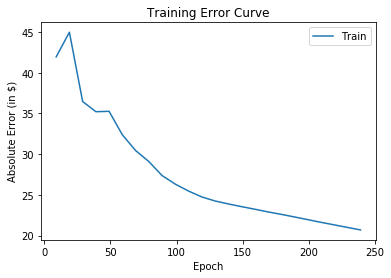

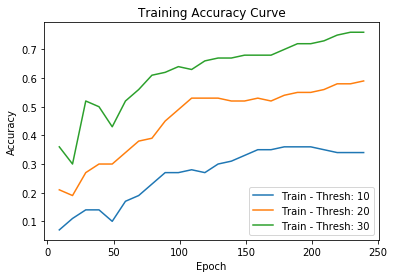

[EPOCH 241] loss: 0.007554  time: 0.078
[EPOCH 242] loss: 0.007531  time: 0.102
[EPOCH 243] loss: 0.007507  time: 0.102
[EPOCH 244] loss: 0.007485  time: 0.095
[EPOCH 245] loss: 0.007462  time: 0.093
[EPOCH 246] loss: 0.007439  time: 0.118
[EPOCH 247] loss: 0.007417  time: 0.098
[EPOCH 248] loss: 0.007395  time: 0.096
[EPOCH 249] loss: 0.007373  time: 0.096
[EPOCH 250] loss: 0.007350  time: 0.294


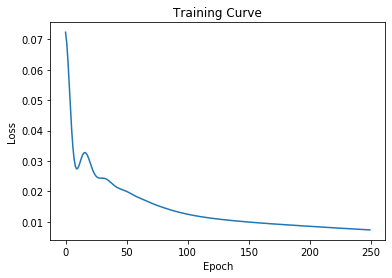

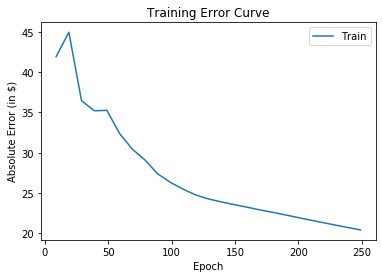

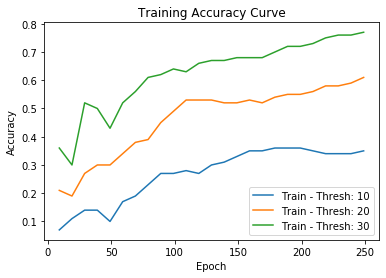

[EPOCH 251] loss: 0.007329  time: 0.076
[EPOCH 252] loss: 0.007307  time: 0.097
[EPOCH 253] loss: 0.007285  time: 0.093
[EPOCH 254] loss: 0.007262  time: 0.103
[EPOCH 255] loss: 0.007241  time: 0.096
[EPOCH 256] loss: 0.007219  time: 0.098
[EPOCH 257] loss: 0.007197  time: 0.098
[EPOCH 258] loss: 0.007175  time: 0.095
[EPOCH 259] loss: 0.007153  time: 0.105
[EPOCH 260] loss: 0.007132  time: 0.357


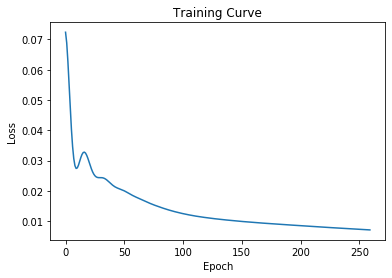

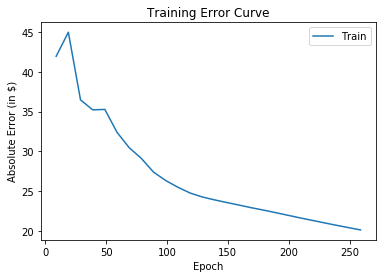

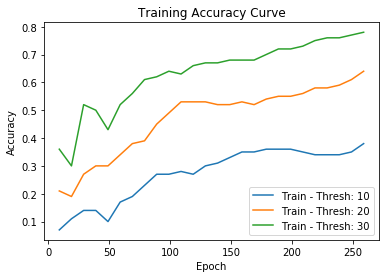

[EPOCH 261] loss: 0.007110  time: 0.093
[EPOCH 262] loss: 0.007088  time: 0.115
[EPOCH 263] loss: 0.007067  time: 0.108
[EPOCH 264] loss: 0.007045  time: 0.109
[EPOCH 265] loss: 0.007023  time: 0.113
[EPOCH 266] loss: 0.007002  time: 0.123
[EPOCH 267] loss: 0.006980  time: 0.127
[EPOCH 268] loss: 0.006958  time: 0.116
[EPOCH 269] loss: 0.006937  time: 0.111
[EPOCH 270] loss: 0.006915  time: 0.360


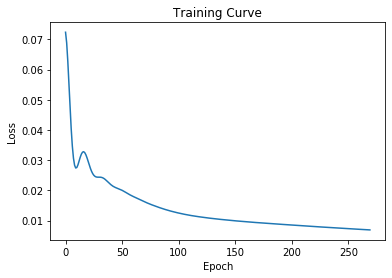

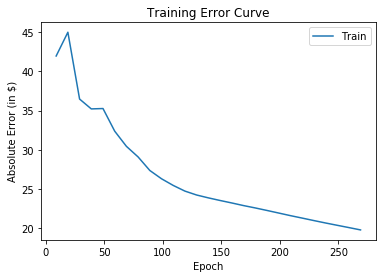

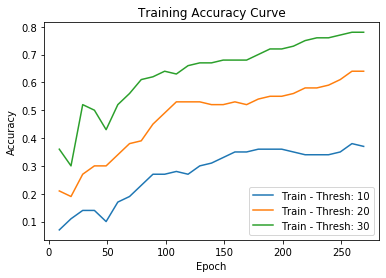

[EPOCH 271] loss: 0.006894  time: 0.091
[EPOCH 272] loss: 0.006872  time: 0.114
[EPOCH 273] loss: 0.006851  time: 0.111
[EPOCH 274] loss: 0.006829  time: 0.117
[EPOCH 275] loss: 0.006808  time: 0.127
[EPOCH 276] loss: 0.006786  time: 0.113
[EPOCH 277] loss: 0.006765  time: 0.127
[EPOCH 278] loss: 0.006743  time: 0.116
[EPOCH 279] loss: 0.006722  time: 0.111
[EPOCH 280] loss: 0.006700  time: 0.345


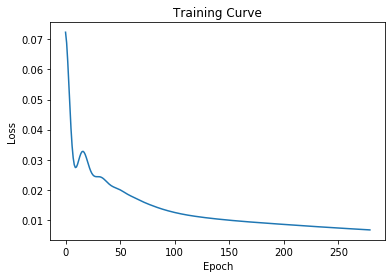

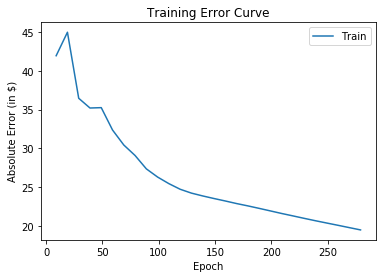

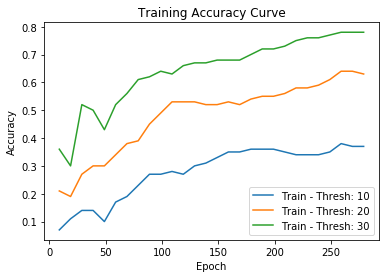

[EPOCH 281] loss: 0.006679  time: 0.091
[EPOCH 282] loss: 0.006658  time: 0.115
[EPOCH 283] loss: 0.006637  time: 0.121
[EPOCH 284] loss: 0.006616  time: 0.116
[EPOCH 285] loss: 0.006595  time: 0.111
[EPOCH 286] loss: 0.006574  time: 0.111
[EPOCH 287] loss: 0.006553  time: 0.113
[EPOCH 288] loss: 0.006532  time: 0.121
[EPOCH 289] loss: 0.006511  time: 0.110
[EPOCH 290] loss: 0.006490  time: 0.307


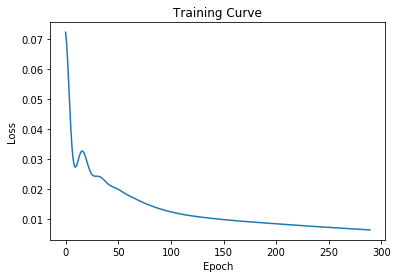

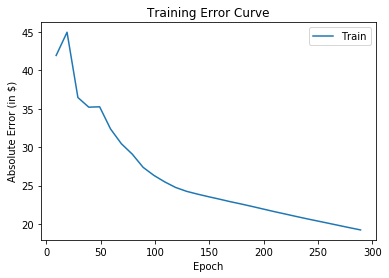

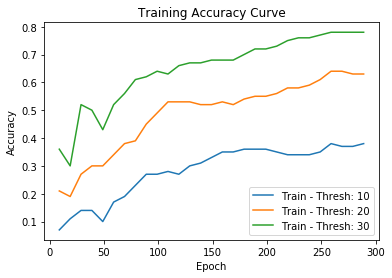

[EPOCH 291] loss: 0.006469  time: 0.078
[EPOCH 292] loss: 0.006448  time: 0.091
[EPOCH 293] loss: 0.006428  time: 0.090
[EPOCH 294] loss: 0.006407  time: 0.100
[EPOCH 295] loss: 0.006386  time: 0.101
[EPOCH 296] loss: 0.006366  time: 0.097
[EPOCH 297] loss: 0.006346  time: 0.098
[EPOCH 298] loss: 0.006326  time: 0.097
[EPOCH 299] loss: 0.006305  time: 0.092
[EPOCH 300] loss: 0.006285  time: 0.291


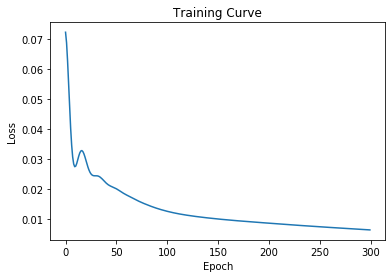

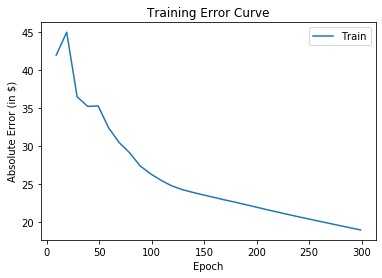

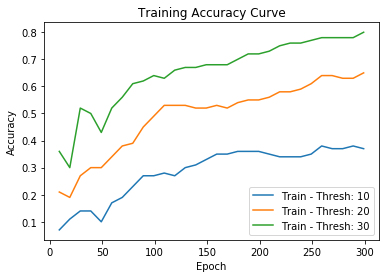

[EPOCH 301] loss: 0.006265  time: 0.076
[EPOCH 302] loss: 0.006245  time: 0.089
[EPOCH 303] loss: 0.006225  time: 0.100
[EPOCH 304] loss: 0.006206  time: 0.142
[EPOCH 305] loss: 0.006186  time: 0.109
[EPOCH 306] loss: 0.006166  time: 0.108
[EPOCH 307] loss: 0.006146  time: 0.110
[EPOCH 308] loss: 0.006127  time: 0.113
[EPOCH 309] loss: 0.006107  time: 0.120
[EPOCH 310] loss: 0.006087  time: 0.330


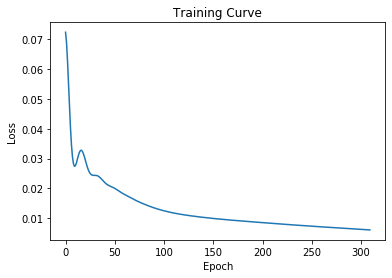

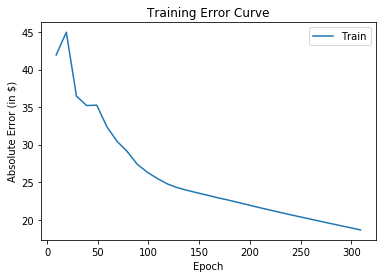

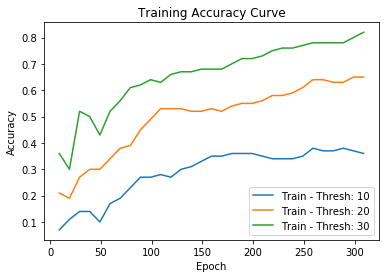

[EPOCH 311] loss: 0.006067  time: 0.080
[EPOCH 312] loss: 0.006047  time: 0.098
[EPOCH 313] loss: 0.006027  time: 0.101
[EPOCH 314] loss: 0.006008  time: 0.103
[EPOCH 315] loss: 0.005988  time: 0.095
[EPOCH 316] loss: 0.005968  time: 0.104
[EPOCH 317] loss: 0.005948  time: 0.103
[EPOCH 318] loss: 0.005928  time: 0.091
[EPOCH 319] loss: 0.005908  time: 0.098
[EPOCH 320] loss: 0.005888  time: 0.295


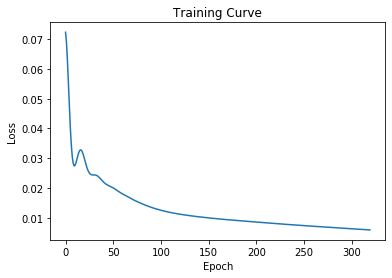

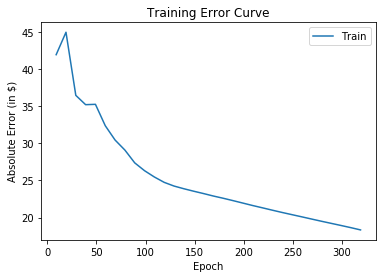

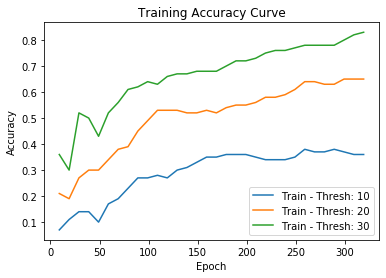

[EPOCH 321] loss: 0.005869  time: 0.077
[EPOCH 322] loss: 0.005849  time: 0.101
[EPOCH 323] loss: 0.005829  time: 0.100
[EPOCH 324] loss: 0.005810  time: 0.102
[EPOCH 325] loss: 0.005790  time: 0.087
[EPOCH 326] loss: 0.005771  time: 0.096
[EPOCH 327] loss: 0.005752  time: 0.099
[EPOCH 328] loss: 0.005733  time: 0.095
[EPOCH 329] loss: 0.005713  time: 0.096
[EPOCH 330] loss: 0.005694  time: 0.293


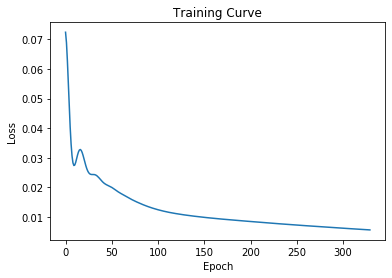

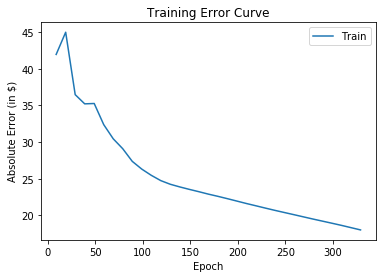

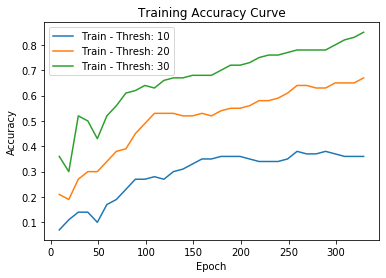

[EPOCH 331] loss: 0.005675  time: 0.076
[EPOCH 332] loss: 0.005656  time: 0.100
[EPOCH 333] loss: 0.005638  time: 0.099
[EPOCH 334] loss: 0.005619  time: 0.100
[EPOCH 335] loss: 0.005600  time: 0.097
[EPOCH 336] loss: 0.005581  time: 0.094
[EPOCH 337] loss: 0.005562  time: 0.107
[EPOCH 338] loss: 0.005544  time: 0.106
[EPOCH 339] loss: 0.005525  time: 0.094
[EPOCH 340] loss: 0.005506  time: 0.296


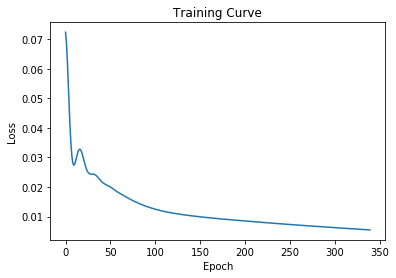

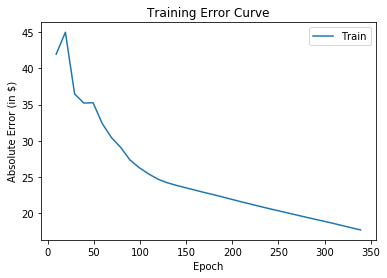

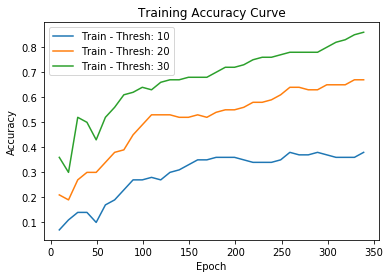

[EPOCH 341] loss: 0.005488  time: 0.078
[EPOCH 342] loss: 0.005469  time: 0.096
[EPOCH 343] loss: 0.005450  time: 0.095
[EPOCH 344] loss: 0.005432  time: 0.121
[EPOCH 345] loss: 0.005413  time: 0.097
[EPOCH 346] loss: 0.005394  time: 0.100
[EPOCH 347] loss: 0.005376  time: 0.104
[EPOCH 348] loss: 0.005358  time: 0.095
[EPOCH 349] loss: 0.005339  time: 0.103
[EPOCH 350] loss: 0.005321  time: 0.315


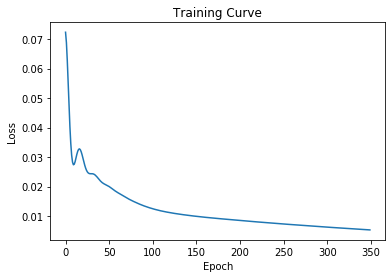

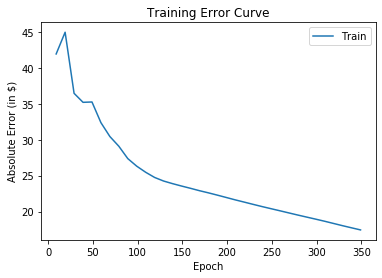

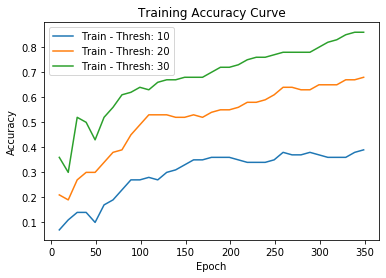

[EPOCH 351] loss: 0.005303  time: 0.075
[EPOCH 352] loss: 0.005285  time: 0.098
[EPOCH 353] loss: 0.005267  time: 0.098
[EPOCH 354] loss: 0.005249  time: 0.105
[EPOCH 355] loss: 0.005231  time: 0.090
[EPOCH 356] loss: 0.005213  time: 0.093
[EPOCH 357] loss: 0.005195  time: 0.105
[EPOCH 358] loss: 0.005177  time: 0.092
[EPOCH 359] loss: 0.005159  time: 0.097
[EPOCH 360] loss: 0.005142  time: 0.296


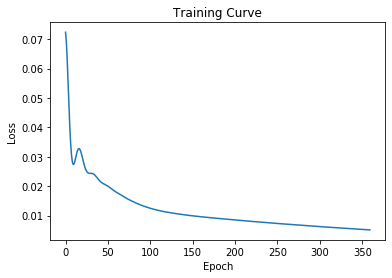

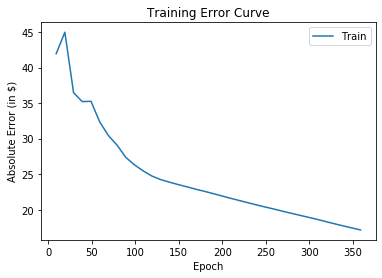

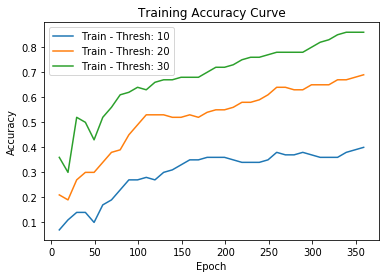

[EPOCH 361] loss: 0.005124  time: 0.075
[EPOCH 362] loss: 0.005107  time: 0.092
[EPOCH 363] loss: 0.005090  time: 0.095
[EPOCH 364] loss: 0.005073  time: 0.104
[EPOCH 365] loss: 0.005055  time: 0.097
[EPOCH 366] loss: 0.005038  time: 0.094
[EPOCH 367] loss: 0.005021  time: 0.104
[EPOCH 368] loss: 0.005004  time: 0.098
[EPOCH 369] loss: 0.004987  time: 0.089
[EPOCH 370] loss: 0.004970  time: 0.291


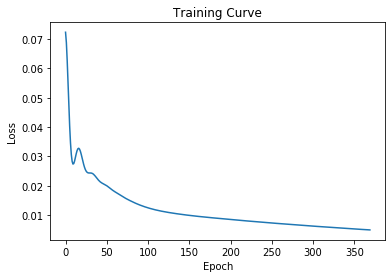

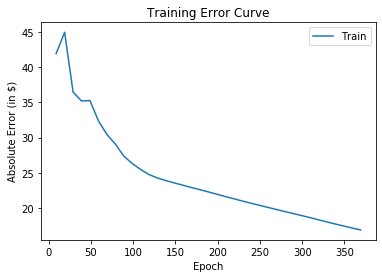

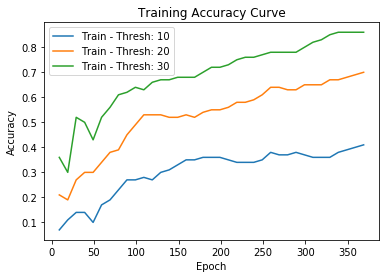

[EPOCH 371] loss: 0.004953  time: 0.086
[EPOCH 372] loss: 0.004937  time: 0.087
[EPOCH 373] loss: 0.004920  time: 0.093
[EPOCH 374] loss: 0.004903  time: 0.101
[EPOCH 375] loss: 0.004886  time: 0.101
[EPOCH 376] loss: 0.004869  time: 0.090
[EPOCH 377] loss: 0.004853  time: 0.112
[EPOCH 378] loss: 0.004836  time: 0.103
[EPOCH 379] loss: 0.004819  time: 0.096
[EPOCH 380] loss: 0.004803  time: 0.314


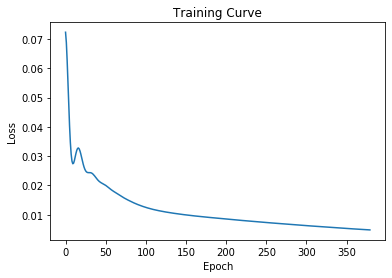

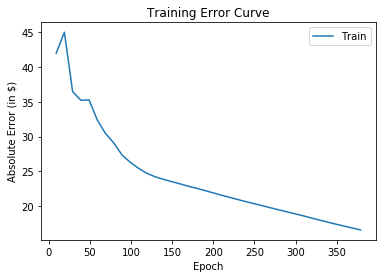

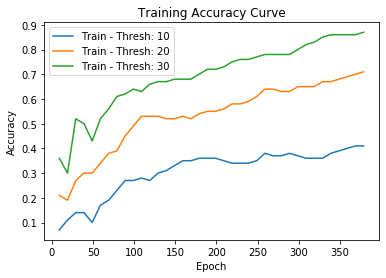

[EPOCH 381] loss: 0.004786  time: 0.076
[EPOCH 382] loss: 0.004769  time: 0.098
[EPOCH 383] loss: 0.004753  time: 0.089
[EPOCH 384] loss: 0.004736  time: 0.109
[EPOCH 385] loss: 0.004720  time: 0.103
[EPOCH 386] loss: 0.004703  time: 0.091
[EPOCH 387] loss: 0.004687  time: 0.099
[EPOCH 388] loss: 0.004670  time: 0.097
[EPOCH 389] loss: 0.004654  time: 0.096
[EPOCH 390] loss: 0.004637  time: 0.290


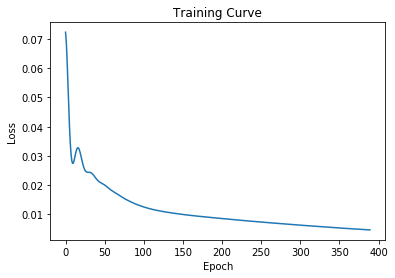

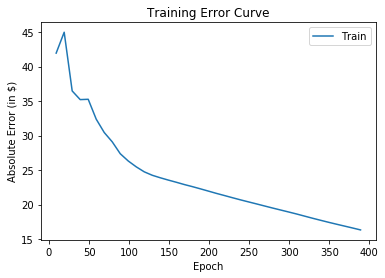

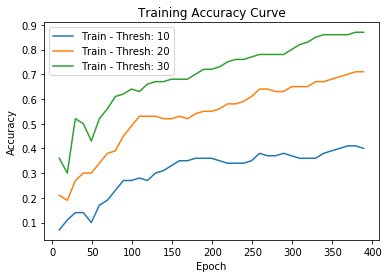

[EPOCH 391] loss: 0.004621  time: 0.075
[EPOCH 392] loss: 0.004605  time: 0.090
[EPOCH 393] loss: 0.004588  time: 0.103
[EPOCH 394] loss: 0.004572  time: 0.110
[EPOCH 395] loss: 0.004555  time: 0.096
[EPOCH 396] loss: 0.004539  time: 0.099
[EPOCH 397] loss: 0.004523  time: 0.103
[EPOCH 398] loss: 0.004507  time: 0.103
[EPOCH 399] loss: 0.004491  time: 0.092
[EPOCH 400] loss: 0.004474  time: 0.292


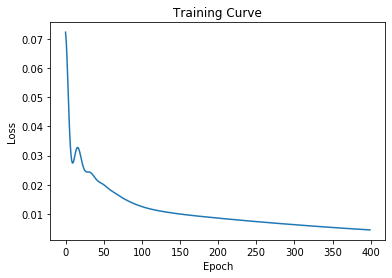

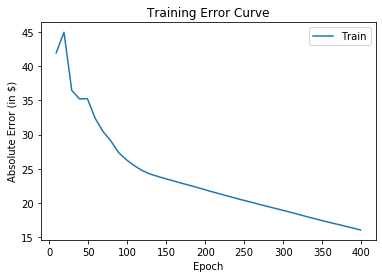

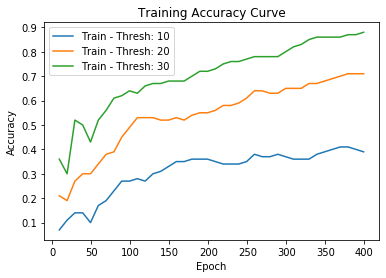

[EPOCH 401] loss: 0.004458  time: 0.081
[EPOCH 402] loss: 0.004442  time: 0.116
[EPOCH 403] loss: 0.004426  time: 0.119
[EPOCH 404] loss: 0.004410  time: 0.115
[EPOCH 405] loss: 0.004394  time: 0.126
[EPOCH 406] loss: 0.004378  time: 0.119
[EPOCH 407] loss: 0.004362  time: 0.124
[EPOCH 408] loss: 0.004346  time: 0.109
[EPOCH 409] loss: 0.004330  time: 0.138
[EPOCH 410] loss: 0.004314  time: 0.296


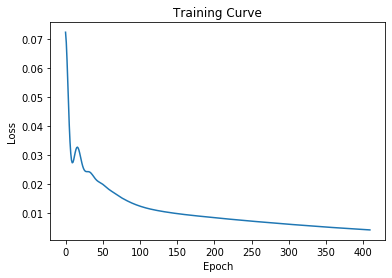

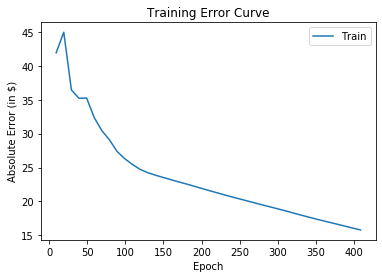

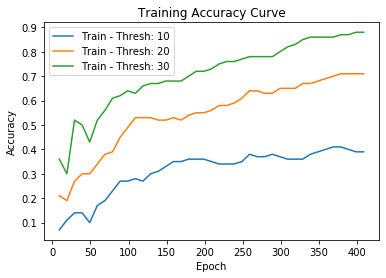

[EPOCH 411] loss: 0.004299  time: 0.075
[EPOCH 412] loss: 0.004283  time: 0.092
[EPOCH 413] loss: 0.004267  time: 0.094
[EPOCH 414] loss: 0.004252  time: 0.096
[EPOCH 415] loss: 0.004236  time: 0.093
[EPOCH 416] loss: 0.004220  time: 0.104
[EPOCH 417] loss: 0.004205  time: 0.108
[EPOCH 418] loss: 0.004189  time: 0.098
[EPOCH 419] loss: 0.004174  time: 0.109
[EPOCH 420] loss: 0.004159  time: 0.289


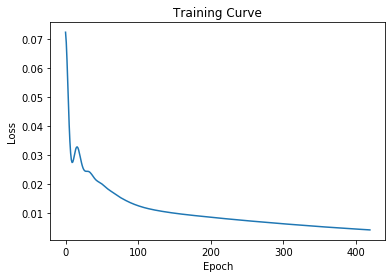

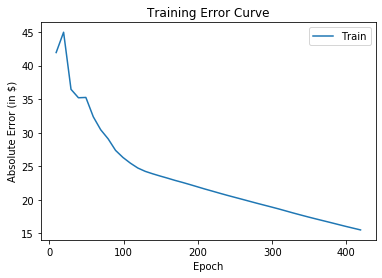

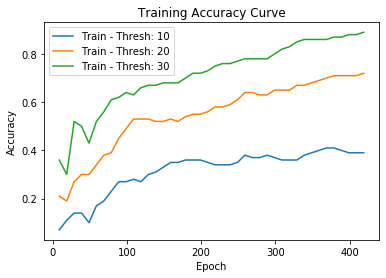

[EPOCH 421] loss: 0.004143  time: 0.075
[EPOCH 422] loss: 0.004128  time: 0.110
[EPOCH 423] loss: 0.004112  time: 0.101
[EPOCH 424] loss: 0.004097  time: 0.099
[EPOCH 425] loss: 0.004082  time: 0.098
[EPOCH 426] loss: 0.004067  time: 0.107
[EPOCH 427] loss: 0.004052  time: 0.100
[EPOCH 428] loss: 0.004037  time: 0.091
[EPOCH 429] loss: 0.004021  time: 0.103
[EPOCH 430] loss: 0.004007  time: 0.302


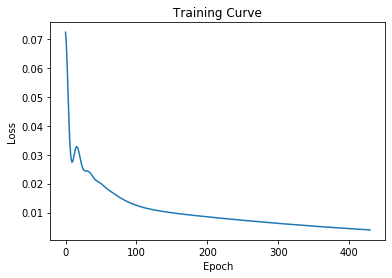

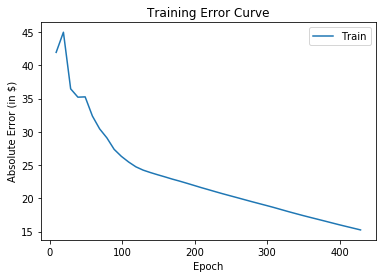

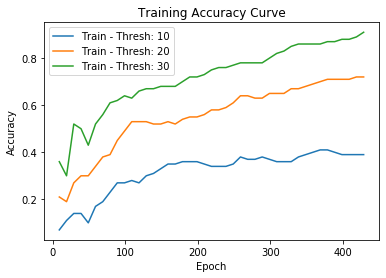

[EPOCH 431] loss: 0.003992  time: 0.076
[EPOCH 432] loss: 0.003977  time: 0.093
[EPOCH 433] loss: 0.003962  time: 0.098
[EPOCH 434] loss: 0.003947  time: 0.096
[EPOCH 435] loss: 0.003932  time: 0.097
[EPOCH 436] loss: 0.003917  time: 0.096
[EPOCH 437] loss: 0.003902  time: 0.112
[EPOCH 438] loss: 0.003887  time: 0.097
[EPOCH 439] loss: 0.003872  time: 0.097
[EPOCH 440] loss: 0.003858  time: 0.285


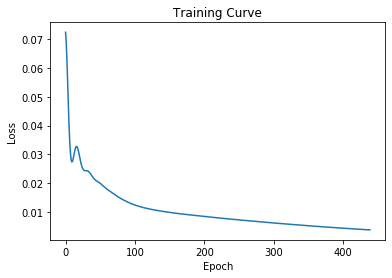

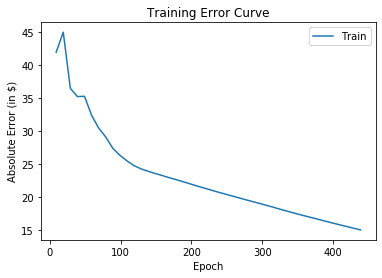

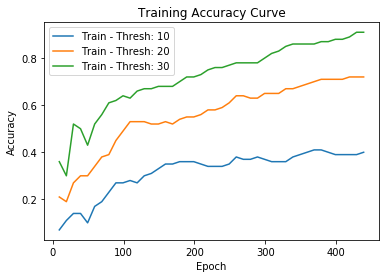

[EPOCH 441] loss: 0.003843  time: 0.077
[EPOCH 442] loss: 0.003828  time: 0.094
[EPOCH 443] loss: 0.003813  time: 0.092
[EPOCH 444] loss: 0.003799  time: 0.109
[EPOCH 445] loss: 0.003784  time: 0.095
[EPOCH 446] loss: 0.003769  time: 0.095
[EPOCH 447] loss: 0.003755  time: 0.102
[EPOCH 448] loss: 0.003740  time: 0.096
[EPOCH 449] loss: 0.003725  time: 0.098
[EPOCH 450] loss: 0.003710  time: 0.284


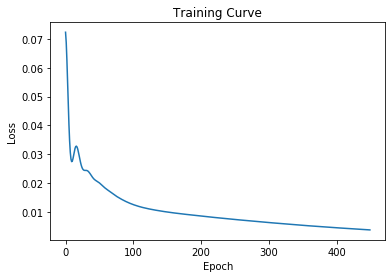

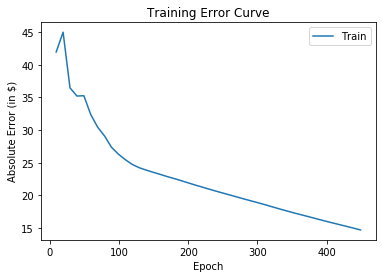

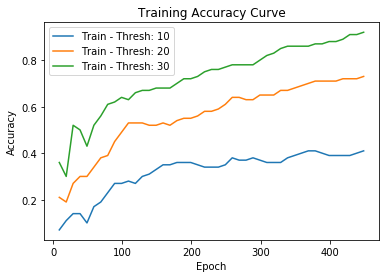

[EPOCH 451] loss: 0.003696  time: 0.076
[EPOCH 452] loss: 0.003681  time: 0.099
[EPOCH 453] loss: 0.003666  time: 0.091
[EPOCH 454] loss: 0.003651  time: 0.105
[EPOCH 455] loss: 0.003636  time: 0.094
[EPOCH 456] loss: 0.003622  time: 0.095
[EPOCH 457] loss: 0.003607  time: 0.110
[EPOCH 458] loss: 0.003593  time: 0.097
[EPOCH 459] loss: 0.003578  time: 0.090
[EPOCH 460] loss: 0.003564  time: 0.289


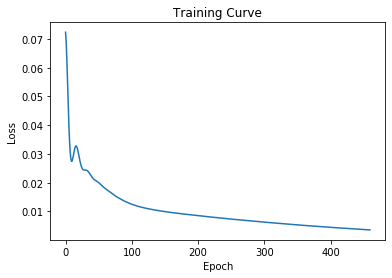

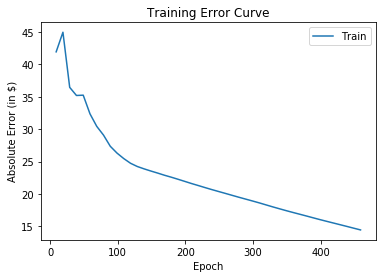

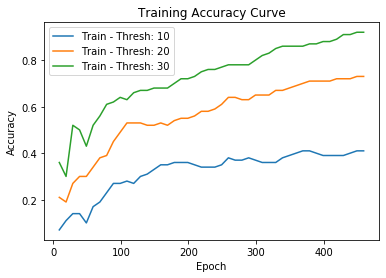

[EPOCH 461] loss: 0.003549  time: 0.077
[EPOCH 462] loss: 0.003535  time: 0.096
[EPOCH 463] loss: 0.003520  time: 0.090
[EPOCH 464] loss: 0.003506  time: 0.100
[EPOCH 465] loss: 0.003491  time: 0.103
[EPOCH 466] loss: 0.003476  time: 0.099
[EPOCH 467] loss: 0.003462  time: 0.100
[EPOCH 468] loss: 0.003448  time: 0.103
[EPOCH 469] loss: 0.003433  time: 0.101
[EPOCH 470] loss: 0.003419  time: 0.294


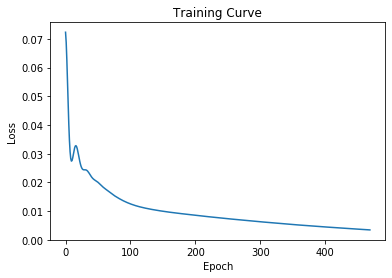

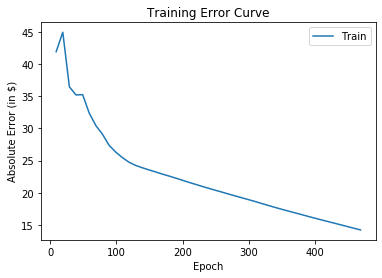

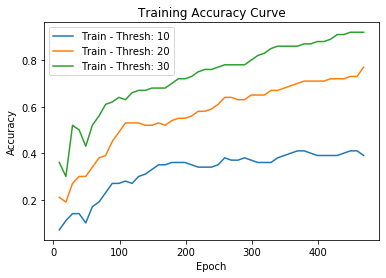

[EPOCH 471] loss: 0.003405  time: 0.083
[EPOCH 472] loss: 0.003391  time: 0.095
[EPOCH 473] loss: 0.003378  time: 0.101
[EPOCH 474] loss: 0.003364  time: 0.104
[EPOCH 475] loss: 0.003351  time: 0.099
[EPOCH 476] loss: 0.003337  time: 0.102
[EPOCH 477] loss: 0.003324  time: 0.098
[EPOCH 478] loss: 0.003311  time: 0.099
[EPOCH 479] loss: 0.003297  time: 0.097
[EPOCH 480] loss: 0.003284  time: 0.304


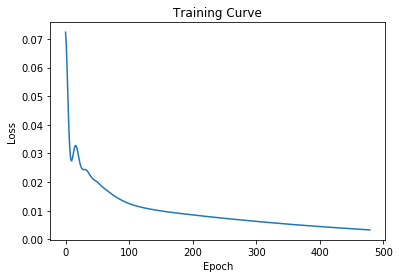

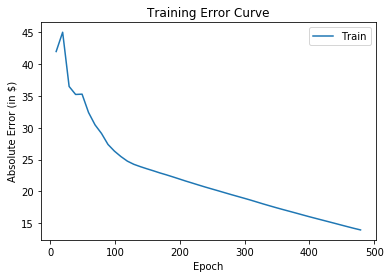

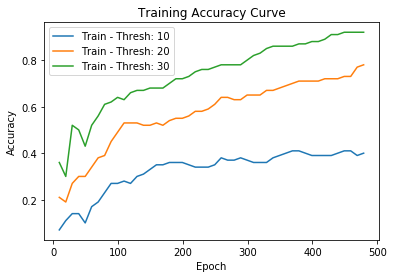

[EPOCH 481] loss: 0.003271  time: 0.085
[EPOCH 482] loss: 0.003257  time: 0.118
[EPOCH 483] loss: 0.003244  time: 0.115
[EPOCH 484] loss: 0.003231  time: 0.127
[EPOCH 485] loss: 0.003218  time: 0.123
[EPOCH 486] loss: 0.003205  time: 0.108
[EPOCH 487] loss: 0.003192  time: 0.108
[EPOCH 488] loss: 0.003179  time: 0.130
[EPOCH 489] loss: 0.003167  time: 0.099
[EPOCH 490] loss: 0.003154  time: 0.287


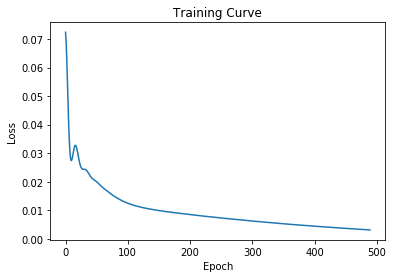

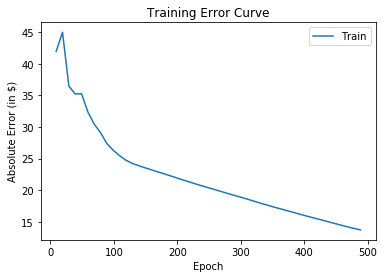

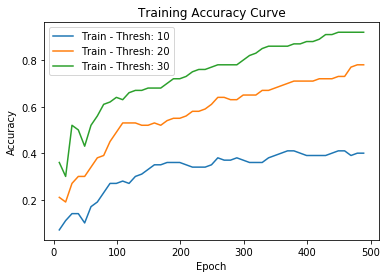

[EPOCH 491] loss: 0.003141  time: 0.076
[EPOCH 492] loss: 0.003129  time: 0.099
[EPOCH 493] loss: 0.003116  time: 0.111
[EPOCH 494] loss: 0.003104  time: 0.123
[EPOCH 495] loss: 0.003091  time: 0.104
[EPOCH 496] loss: 0.003079  time: 0.103
[EPOCH 497] loss: 0.003067  time: 0.103
[EPOCH 498] loss: 0.003054  time: 0.112
[EPOCH 499] loss: 0.003042  time: 0.101
[EPOCH 500] loss: 0.003030  time: 0.315


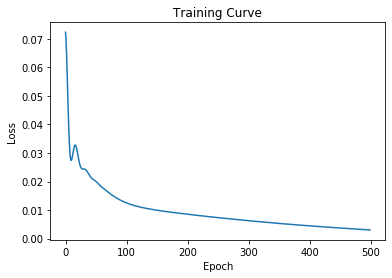

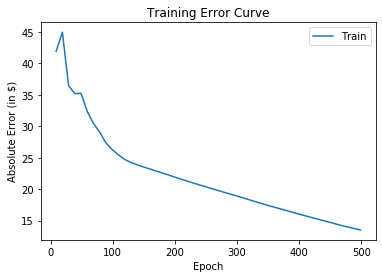

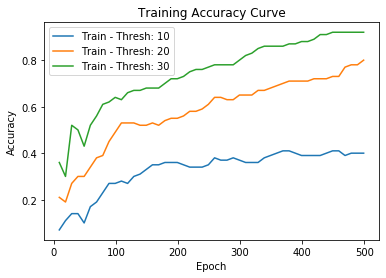

[EPOCH 501] loss: 0.003018  time: 0.077
[EPOCH 502] loss: 0.003006  time: 0.105
[EPOCH 503] loss: 0.002994  time: 0.105
[EPOCH 504] loss: 0.002982  time: 0.101
[EPOCH 505] loss: 0.002970  time: 0.093
[EPOCH 506] loss: 0.002958  time: 0.101
[EPOCH 507] loss: 0.002947  time: 0.091
[EPOCH 508] loss: 0.002935  time: 0.097
[EPOCH 509] loss: 0.002923  time: 0.101
[EPOCH 510] loss: 0.002912  time: 0.305


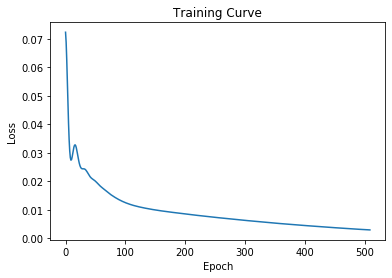

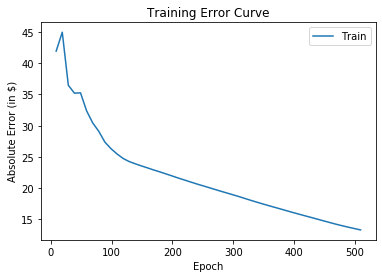

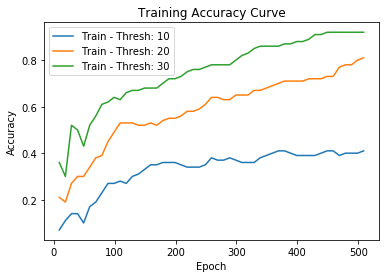

[EPOCH 511] loss: 0.002900  time: 0.082
[EPOCH 512] loss: 0.002889  time: 0.095
[EPOCH 513] loss: 0.002878  time: 0.093
[EPOCH 514] loss: 0.002866  time: 0.100
[EPOCH 515] loss: 0.002855  time: 0.102
[EPOCH 516] loss: 0.002844  time: 0.101
[EPOCH 517] loss: 0.002833  time: 0.097
[EPOCH 518] loss: 0.002822  time: 0.092
[EPOCH 519] loss: 0.002810  time: 0.099
[EPOCH 520] loss: 0.002799  time: 0.291


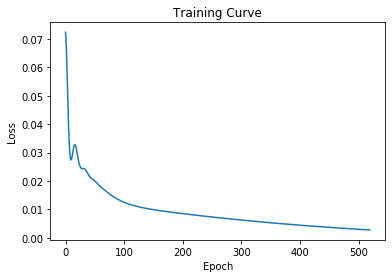

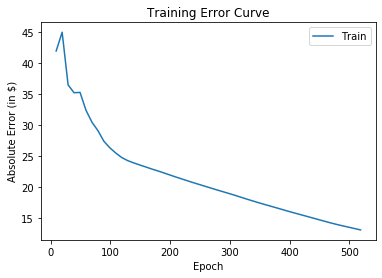

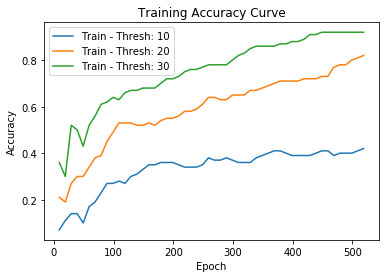

[EPOCH 521] loss: 0.002788  time: 0.077
[EPOCH 522] loss: 0.002777  time: 0.092
[EPOCH 523] loss: 0.002767  time: 0.097
[EPOCH 524] loss: 0.002756  time: 0.100
[EPOCH 525] loss: 0.002745  time: 0.092
[EPOCH 526] loss: 0.002734  time: 0.096
[EPOCH 527] loss: 0.002723  time: 0.096
[EPOCH 528] loss: 0.002713  time: 0.095
[EPOCH 529] loss: 0.002702  time: 0.089
[EPOCH 530] loss: 0.002691  time: 0.291


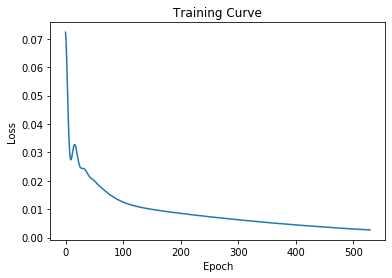

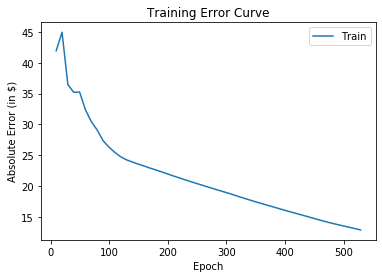

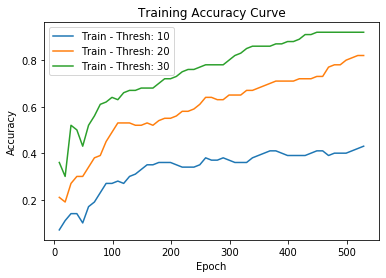

[EPOCH 531] loss: 0.002681  time: 0.080
[EPOCH 532] loss: 0.002670  time: 0.101
[EPOCH 533] loss: 0.002660  time: 0.110
[EPOCH 534] loss: 0.002649  time: 0.095
[EPOCH 535] loss: 0.002639  time: 0.094
[EPOCH 536] loss: 0.002628  time: 0.102
[EPOCH 537] loss: 0.002618  time: 0.098
[EPOCH 538] loss: 0.002608  time: 0.099
[EPOCH 539] loss: 0.002598  time: 0.100
[EPOCH 540] loss: 0.002587  time: 0.296


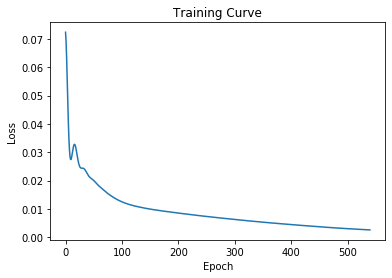

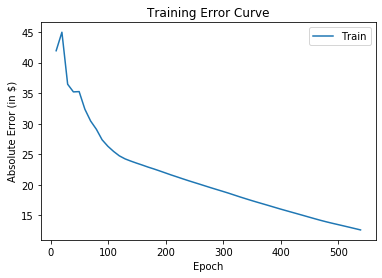

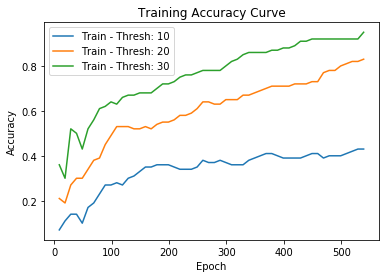

[EPOCH 541] loss: 0.002577  time: 0.081
[EPOCH 542] loss: 0.002567  time: 0.100
[EPOCH 543] loss: 0.002557  time: 0.101
[EPOCH 544] loss: 0.002547  time: 0.107
[EPOCH 545] loss: 0.002537  time: 0.099
[EPOCH 546] loss: 0.002527  time: 0.101
[EPOCH 547] loss: 0.002517  time: 0.090
[EPOCH 548] loss: 0.002507  time: 0.105
[EPOCH 549] loss: 0.002497  time: 0.096
[EPOCH 550] loss: 0.002488  time: 0.289


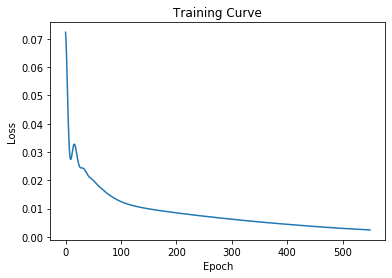

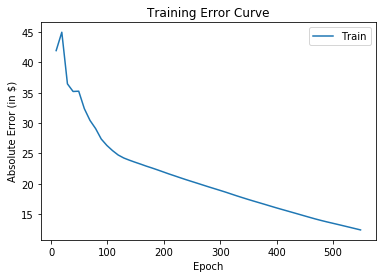

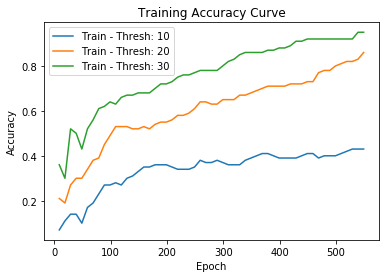

[EPOCH 551] loss: 0.002478  time: 0.085
[EPOCH 552] loss: 0.002468  time: 0.084
[EPOCH 553] loss: 0.002458  time: 0.095
[EPOCH 554] loss: 0.002449  time: 0.101
[EPOCH 555] loss: 0.002439  time: 0.094
[EPOCH 556] loss: 0.002429  time: 0.097
[EPOCH 557] loss: 0.002420  time: 0.106
[EPOCH 558] loss: 0.002410  time: 0.099
[EPOCH 559] loss: 0.002401  time: 0.089
[EPOCH 560] loss: 0.002392  time: 0.299


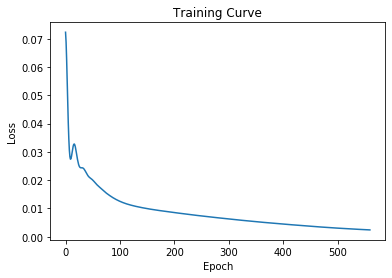

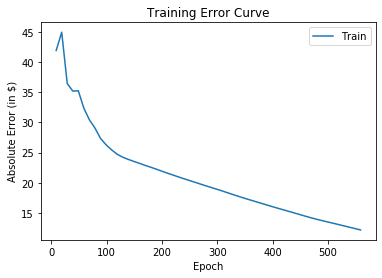

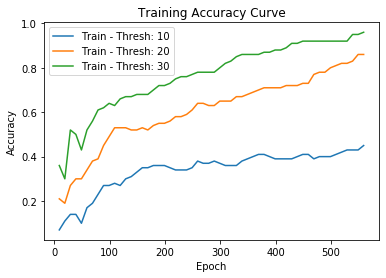

[EPOCH 561] loss: 0.002382  time: 0.082
[EPOCH 562] loss: 0.002373  time: 0.098
[EPOCH 563] loss: 0.002363  time: 0.096
[EPOCH 564] loss: 0.002354  time: 0.105
[EPOCH 565] loss: 0.002345  time: 0.108
[EPOCH 566] loss: 0.002335  time: 0.100
[EPOCH 567] loss: 0.002326  time: 0.100
[EPOCH 568] loss: 0.002317  time: 0.097
[EPOCH 569] loss: 0.002308  time: 0.099
[EPOCH 570] loss: 0.002299  time: 0.288


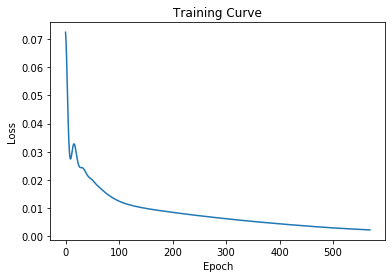

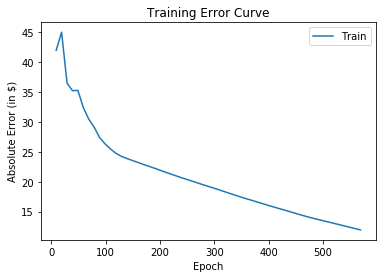

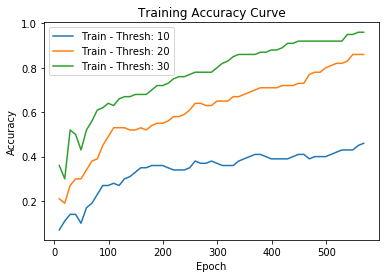

[EPOCH 571] loss: 0.002290  time: 0.076
[EPOCH 572] loss: 0.002281  time: 0.096
[EPOCH 573] loss: 0.002272  time: 0.095
[EPOCH 574] loss: 0.002263  time: 0.104
[EPOCH 575] loss: 0.002254  time: 0.107
[EPOCH 576] loss: 0.002245  time: 0.100
[EPOCH 577] loss: 0.002236  time: 0.096
[EPOCH 578] loss: 0.002227  time: 0.101
[EPOCH 579] loss: 0.002218  time: 0.111
[EPOCH 580] loss: 0.002209  time: 0.283


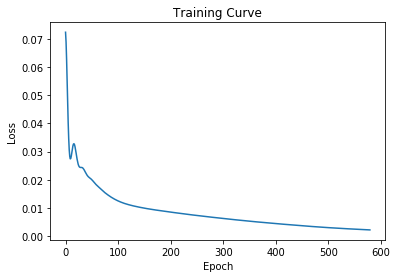

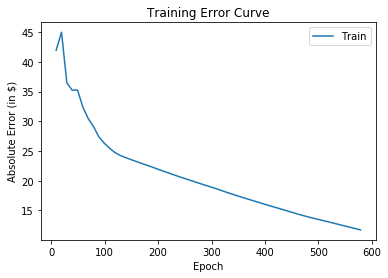

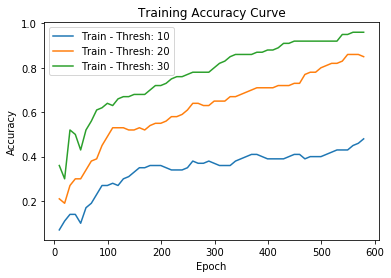

[EPOCH 581] loss: 0.002201  time: 0.080
[EPOCH 582] loss: 0.002192  time: 0.097
[EPOCH 583] loss: 0.002183  time: 0.095
[EPOCH 584] loss: 0.002175  time: 0.101
[EPOCH 585] loss: 0.002166  time: 0.093
[EPOCH 586] loss: 0.002157  time: 0.098
[EPOCH 587] loss: 0.002149  time: 0.104
[EPOCH 588] loss: 0.002140  time: 0.095
[EPOCH 589] loss: 0.002132  time: 0.091
[EPOCH 590] loss: 0.002124  time: 0.297


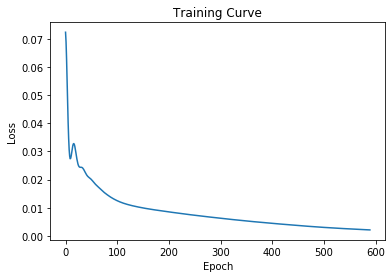

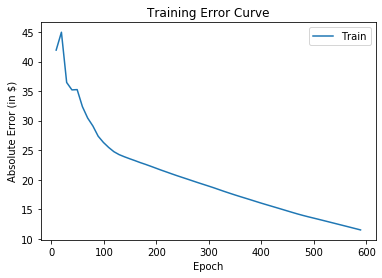

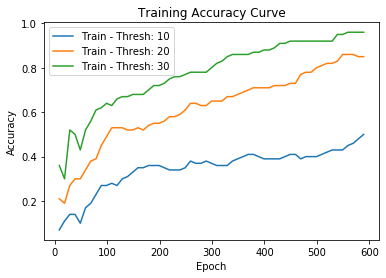

[EPOCH 591] loss: 0.002115  time: 0.081
[EPOCH 592] loss: 0.002107  time: 0.091
[EPOCH 593] loss: 0.002098  time: 0.096
[EPOCH 594] loss: 0.002090  time: 0.102
[EPOCH 595] loss: 0.002082  time: 0.103
[EPOCH 596] loss: 0.002074  time: 0.094
[EPOCH 597] loss: 0.002065  time: 0.103
[EPOCH 598] loss: 0.002057  time: 0.100
[EPOCH 599] loss: 0.002049  time: 0.097
[EPOCH 600] loss: 0.002041  time: 0.313


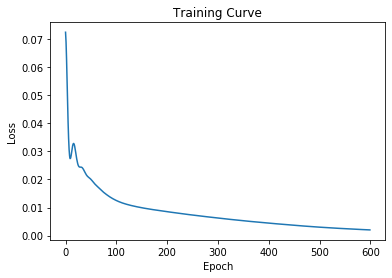

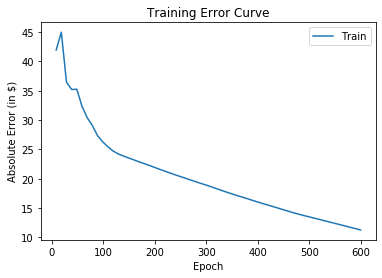

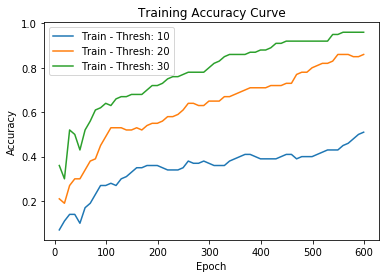

[EPOCH 601] loss: 0.002033  time: 0.076
[EPOCH 602] loss: 0.002025  time: 0.092
[EPOCH 603] loss: 0.002017  time: 0.098
[EPOCH 604] loss: 0.002009  time: 0.100
[EPOCH 605] loss: 0.002001  time: 0.106
[EPOCH 606] loss: 0.001993  time: 0.089
[EPOCH 607] loss: 0.001985  time: 0.101
[EPOCH 608] loss: 0.001977  time: 0.097
[EPOCH 609] loss: 0.001970  time: 0.095
[EPOCH 610] loss: 0.001962  time: 0.297


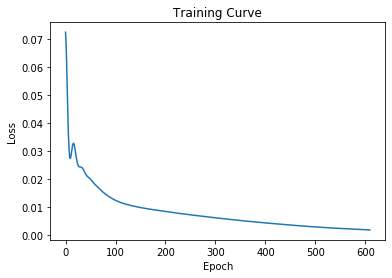

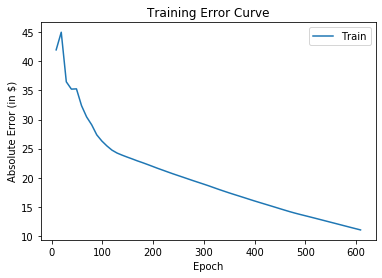

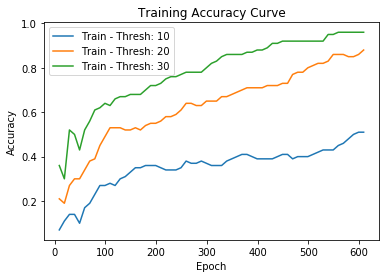

[EPOCH 611] loss: 0.001954  time: 0.076
[EPOCH 612] loss: 0.001946  time: 0.093
[EPOCH 613] loss: 0.001938  time: 0.110
[EPOCH 614] loss: 0.001931  time: 0.096
[EPOCH 615] loss: 0.001923  time: 0.093
[EPOCH 616] loss: 0.001915  time: 0.105
[EPOCH 617] loss: 0.001908  time: 0.093
[EPOCH 618] loss: 0.001900  time: 0.097
[EPOCH 619] loss: 0.001893  time: 0.112
[EPOCH 620] loss: 0.001885  time: 0.278


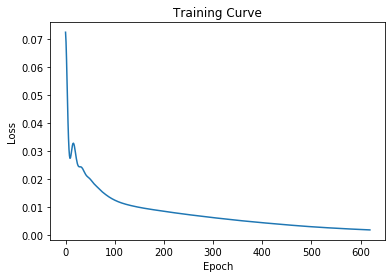

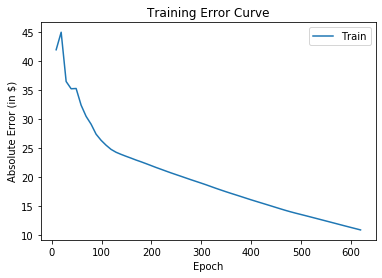

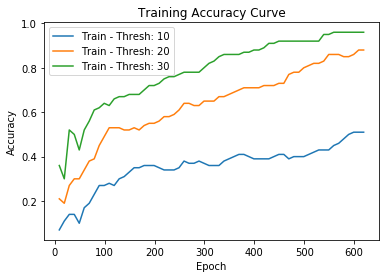

[EPOCH 621] loss: 0.001878  time: 0.076
[EPOCH 622] loss: 0.001870  time: 0.083
[EPOCH 623] loss: 0.001863  time: 0.103
[EPOCH 624] loss: 0.001855  time: 0.100
[EPOCH 625] loss: 0.001848  time: 0.098
[EPOCH 626] loss: 0.001841  time: 0.091
[EPOCH 627] loss: 0.001833  time: 0.100
[EPOCH 628] loss: 0.001826  time: 0.101
[EPOCH 629] loss: 0.001818  time: 0.092
[EPOCH 630] loss: 0.001811  time: 0.278


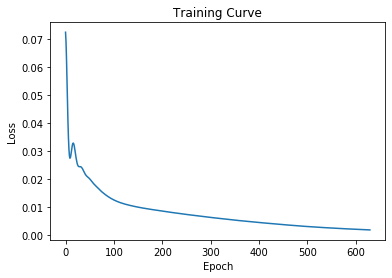

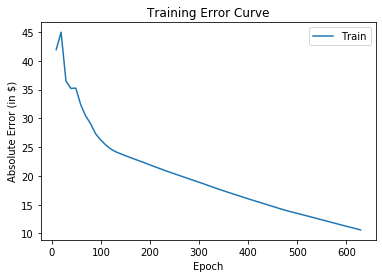

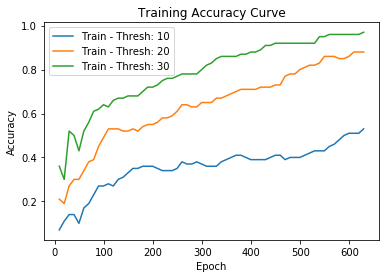

[EPOCH 631] loss: 0.001804  time: 0.080
[EPOCH 632] loss: 0.001797  time: 0.099
[EPOCH 633] loss: 0.001790  time: 0.097
[EPOCH 634] loss: 0.001782  time: 0.095
[EPOCH 635] loss: 0.001775  time: 0.091
[EPOCH 636] loss: 0.001768  time: 0.093
[EPOCH 637] loss: 0.001761  time: 0.102
[EPOCH 638] loss: 0.001754  time: 0.100
[EPOCH 639] loss: 0.001747  time: 0.091
[EPOCH 640] loss: 0.001740  time: 0.299


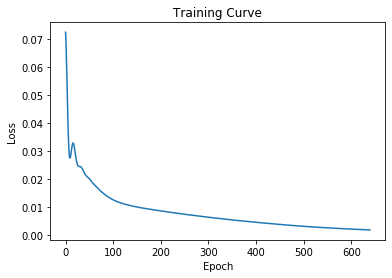

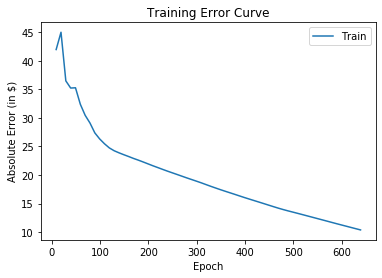

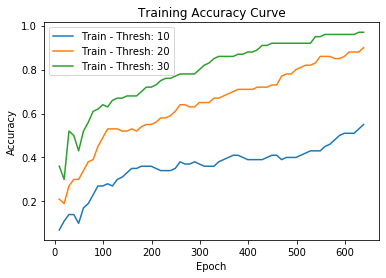

[EPOCH 641] loss: 0.001733  time: 0.081
[EPOCH 642] loss: 0.001726  time: 0.090
[EPOCH 643] loss: 0.001719  time: 0.092
[EPOCH 644] loss: 0.001712  time: 0.098
[EPOCH 645] loss: 0.001705  time: 0.100
[EPOCH 646] loss: 0.001698  time: 0.092
[EPOCH 647] loss: 0.001692  time: 0.099
[EPOCH 648] loss: 0.001685  time: 0.091
[EPOCH 649] loss: 0.001678  time: 0.095
[EPOCH 650] loss: 0.001671  time: 0.295


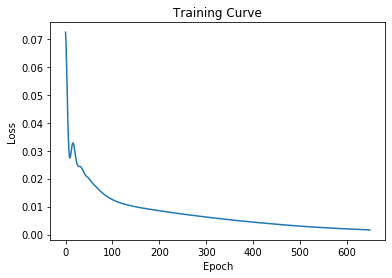

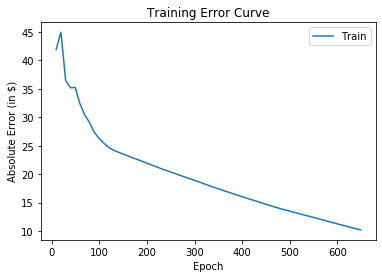

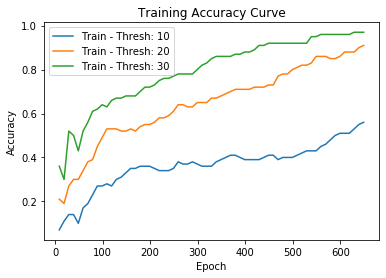

[EPOCH 651] loss: 0.001665  time: 0.076
[EPOCH 652] loss: 0.001658  time: 0.098
[EPOCH 653] loss: 0.001651  time: 0.096
[EPOCH 654] loss: 0.001645  time: 0.110
[EPOCH 655] loss: 0.001638  time: 0.101
[EPOCH 656] loss: 0.001632  time: 0.091
[EPOCH 657] loss: 0.001625  time: 0.102
[EPOCH 658] loss: 0.001619  time: 0.102
[EPOCH 659] loss: 0.001612  time: 0.092
[EPOCH 660] loss: 0.001606  time: 0.291


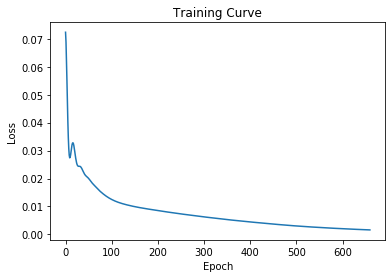

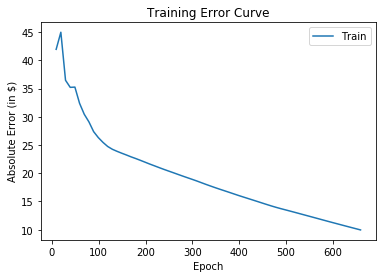

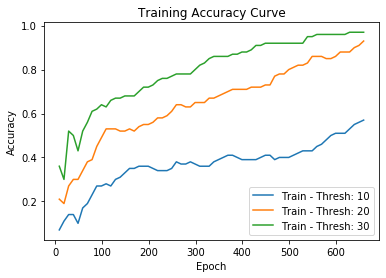

[EPOCH 661] loss: 0.001599  time: 0.080
[EPOCH 662] loss: 0.001593  time: 0.103
[EPOCH 663] loss: 0.001586  time: 0.091
[EPOCH 664] loss: 0.001580  time: 0.102
[EPOCH 665] loss: 0.001574  time: 0.097
[EPOCH 666] loss: 0.001567  time: 0.089
[EPOCH 667] loss: 0.001561  time: 0.092
[EPOCH 668] loss: 0.001555  time: 0.098
[EPOCH 669] loss: 0.001548  time: 0.103
[EPOCH 670] loss: 0.001542  time: 0.293


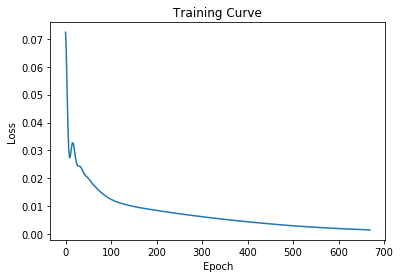

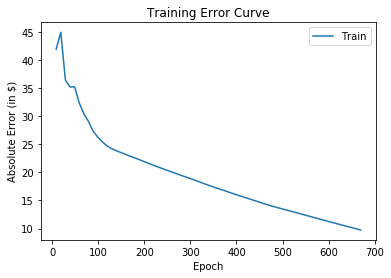

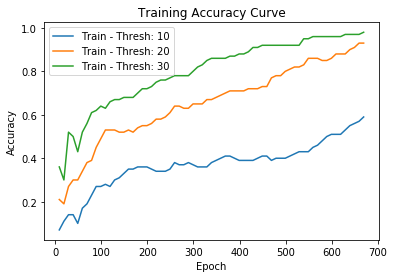

[EPOCH 671] loss: 0.001536  time: 0.081
[EPOCH 672] loss: 0.001530  time: 0.097
[EPOCH 673] loss: 0.001524  time: 0.094
[EPOCH 674] loss: 0.001518  time: 0.099
[EPOCH 675] loss: 0.001511  time: 0.094
[EPOCH 676] loss: 0.001505  time: 0.108
[EPOCH 677] loss: 0.001499  time: 0.105
[EPOCH 678] loss: 0.001493  time: 0.095
[EPOCH 679] loss: 0.001487  time: 0.091
[EPOCH 680] loss: 0.001481  time: 0.292


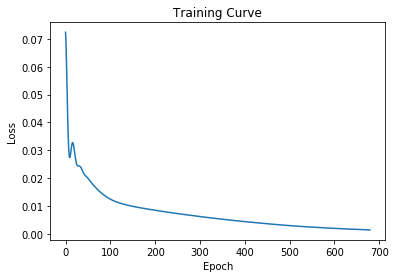

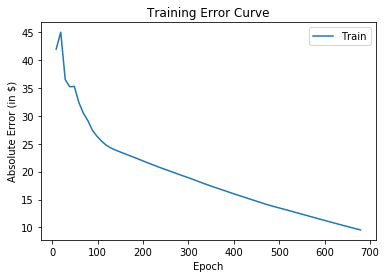

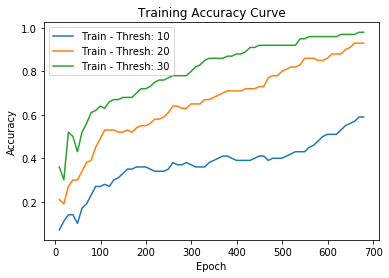

[EPOCH 681] loss: 0.001475  time: 0.077
[EPOCH 682] loss: 0.001470  time: 0.093
[EPOCH 683] loss: 0.001464  time: 0.096
[EPOCH 684] loss: 0.001458  time: 0.099
[EPOCH 685] loss: 0.001452  time: 0.098
[EPOCH 686] loss: 0.001446  time: 0.102
[EPOCH 687] loss: 0.001440  time: 0.101
[EPOCH 688] loss: 0.001434  time: 0.095
[EPOCH 689] loss: 0.001429  time: 0.098
[EPOCH 690] loss: 0.001423  time: 0.289


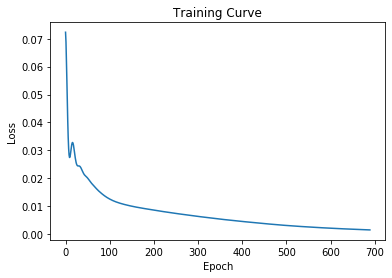

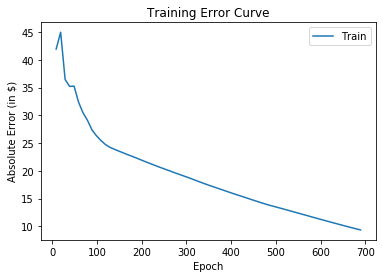

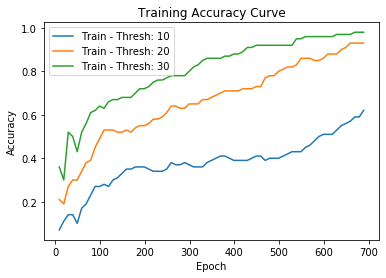

[EPOCH 691] loss: 0.001417  time: 0.077
[EPOCH 692] loss: 0.001411  time: 0.101
[EPOCH 693] loss: 0.001406  time: 0.101
[EPOCH 694] loss: 0.001400  time: 0.102
[EPOCH 695] loss: 0.001395  time: 0.097
[EPOCH 696] loss: 0.001389  time: 0.099
[EPOCH 697] loss: 0.001383  time: 0.097
[EPOCH 698] loss: 0.001378  time: 0.098
[EPOCH 699] loss: 0.001372  time: 0.101
[EPOCH 700] loss: 0.001367  time: 0.291


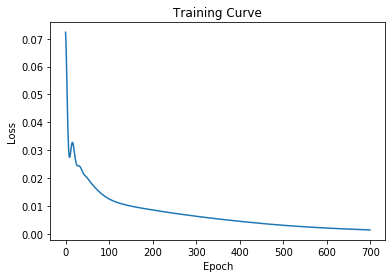

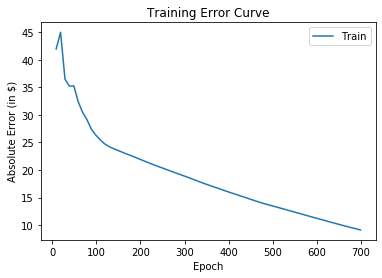

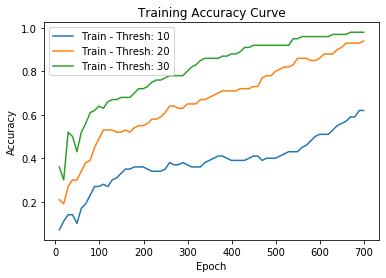

[EPOCH 701] loss: 0.001361  time: 0.081
[EPOCH 702] loss: 0.001356  time: 0.098
[EPOCH 703] loss: 0.001350  time: 0.096
[EPOCH 704] loss: 0.001345  time: 0.100
[EPOCH 705] loss: 0.001339  time: 0.098
[EPOCH 706] loss: 0.001334  time: 0.101
[EPOCH 707] loss: 0.001329  time: 0.112
[EPOCH 708] loss: 0.001323  time: 0.097
[EPOCH 709] loss: 0.001318  time: 0.094
[EPOCH 710] loss: 0.001313  time: 0.315


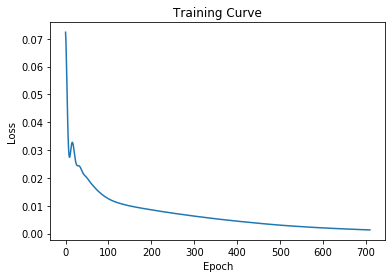

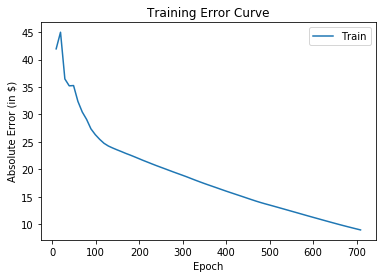

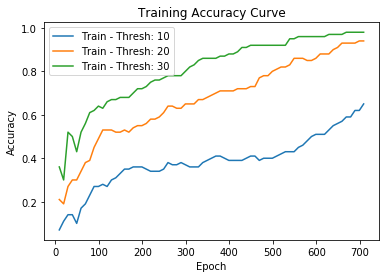

[EPOCH 711] loss: 0.001307  time: 0.076
[EPOCH 712] loss: 0.001302  time: 0.096
[EPOCH 713] loss: 0.001297  time: 0.098
[EPOCH 714] loss: 0.001292  time: 0.116
[EPOCH 715] loss: 0.001287  time: 0.097
[EPOCH 716] loss: 0.001281  time: 0.100
[EPOCH 717] loss: 0.001276  time: 0.108
[EPOCH 718] loss: 0.001271  time: 0.095
[EPOCH 719] loss: 0.001266  time: 0.096
[EPOCH 720] loss: 0.001261  time: 0.300


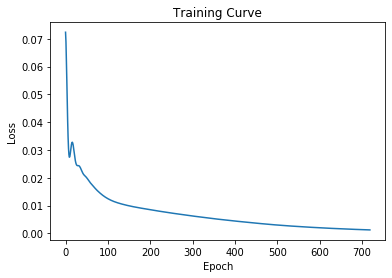

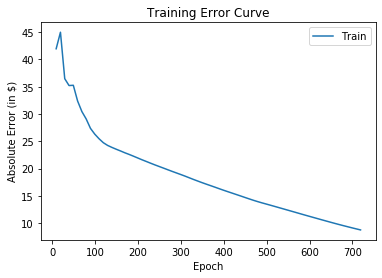

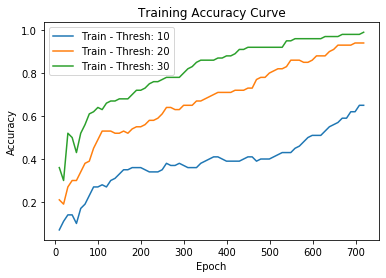

[EPOCH 721] loss: 0.001256  time: 0.077
[EPOCH 722] loss: 0.001251  time: 0.109
[EPOCH 723] loss: 0.001246  time: 0.108
[EPOCH 724] loss: 0.001241  time: 0.098
[EPOCH 725] loss: 0.001236  time: 0.101
[EPOCH 726] loss: 0.001231  time: 0.101
[EPOCH 727] loss: 0.001226  time: 0.101
[EPOCH 728] loss: 0.001221  time: 0.104
[EPOCH 729] loss: 0.001216  time: 0.106
[EPOCH 730] loss: 0.001211  time: 0.286


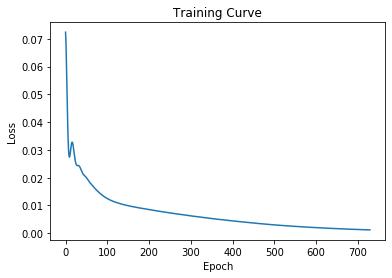

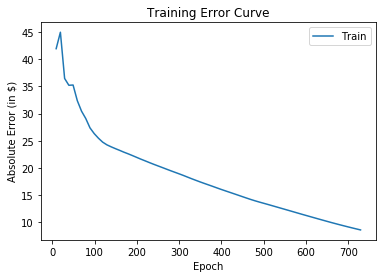

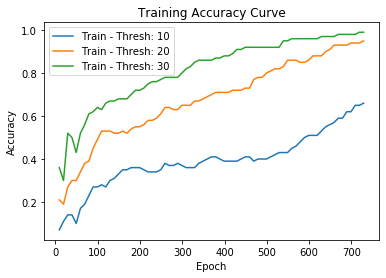

[EPOCH 731] loss: 0.001206  time: 0.082
[EPOCH 732] loss: 0.001202  time: 0.087
[EPOCH 733] loss: 0.001197  time: 0.101
[EPOCH 734] loss: 0.001192  time: 0.099
[EPOCH 735] loss: 0.001187  time: 0.106
[EPOCH 736] loss: 0.001182  time: 0.095
[EPOCH 737] loss: 0.001178  time: 0.098
[EPOCH 738] loss: 0.001173  time: 0.100
[EPOCH 739] loss: 0.001168  time: 0.103
[EPOCH 740] loss: 0.001163  time: 0.326


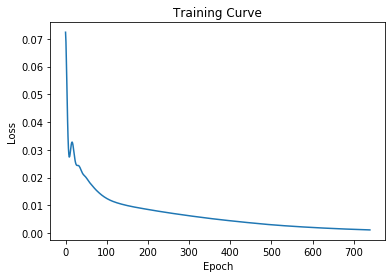

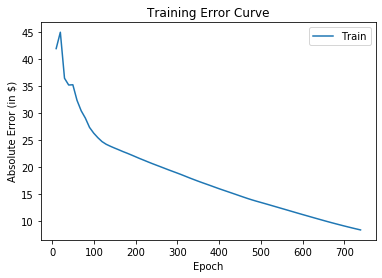

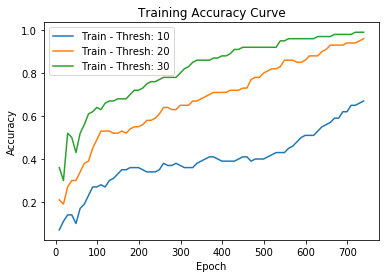

[EPOCH 741] loss: 0.001159  time: 0.102
[EPOCH 742] loss: 0.001154  time: 0.110
[EPOCH 743] loss: 0.001150  time: 0.114
[EPOCH 744] loss: 0.001145  time: 0.097
[EPOCH 745] loss: 0.001140  time: 0.096
[EPOCH 746] loss: 0.001136  time: 0.153
[EPOCH 747] loss: 0.001131  time: 0.160
[EPOCH 748] loss: 0.001127  time: 0.112
[EPOCH 749] loss: 0.001122  time: 0.094
[EPOCH 750] loss: 0.001118  time: 0.284


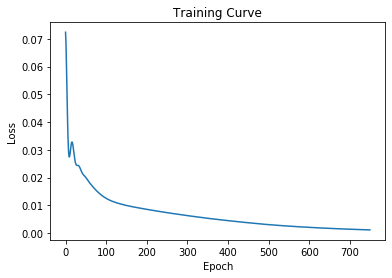

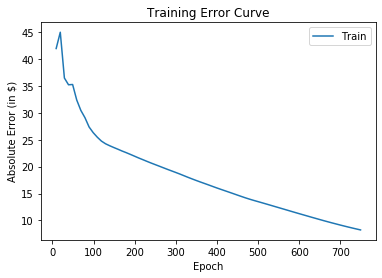

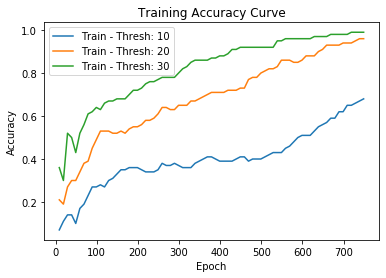

[EPOCH 751] loss: 0.001113  time: 0.076
[EPOCH 752] loss: 0.001109  time: 0.094
[EPOCH 753] loss: 0.001105  time: 0.094
[EPOCH 754] loss: 0.001100  time: 0.103
[EPOCH 755] loss: 0.001096  time: 0.119
[EPOCH 756] loss: 0.001092  time: 0.113
[EPOCH 757] loss: 0.001087  time: 0.106
[EPOCH 758] loss: 0.001083  time: 0.107
[EPOCH 759] loss: 0.001079  time: 0.103
[EPOCH 760] loss: 0.001074  time: 0.374


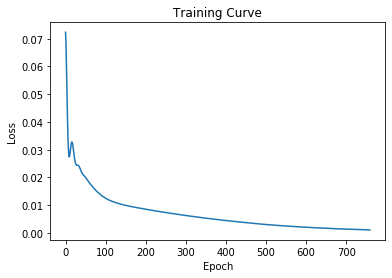

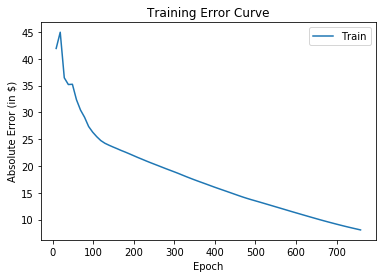

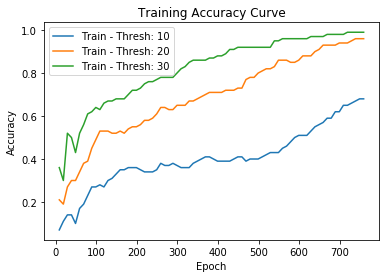

[EPOCH 761] loss: 0.001070  time: 0.080
[EPOCH 762] loss: 0.001066  time: 0.099
[EPOCH 763] loss: 0.001061  time: 0.115
[EPOCH 764] loss: 0.001057  time: 0.127
[EPOCH 765] loss: 0.001053  time: 0.121
[EPOCH 766] loss: 0.001049  time: 0.116
[EPOCH 767] loss: 0.001045  time: 0.119
[EPOCH 768] loss: 0.001041  time: 0.127
[EPOCH 769] loss: 0.001036  time: 0.156
[EPOCH 770] loss: 0.001032  time: 0.369


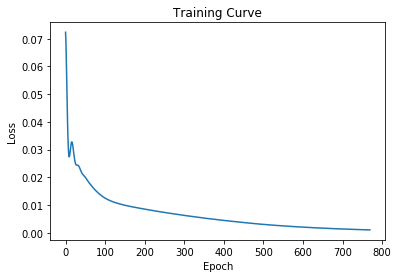

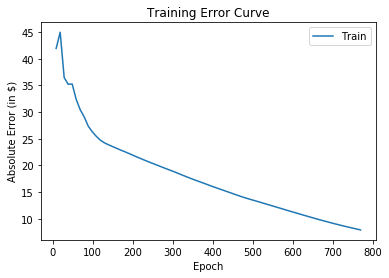

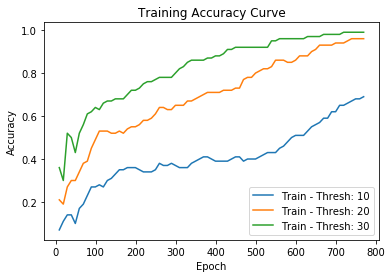

[EPOCH 771] loss: 0.001028  time: 0.078
[EPOCH 772] loss: 0.001024  time: 0.100
[EPOCH 773] loss: 0.001020  time: 0.099
[EPOCH 774] loss: 0.001016  time: 0.130
[EPOCH 775] loss: 0.001012  time: 0.096
[EPOCH 776] loss: 0.001008  time: 0.125
[EPOCH 777] loss: 0.001004  time: 0.095
[EPOCH 778] loss: 0.001000  time: 0.089
[EPOCH 779] loss: 0.000996  time: 0.099
[EPOCH 780] loss: 0.000992  time: 0.316


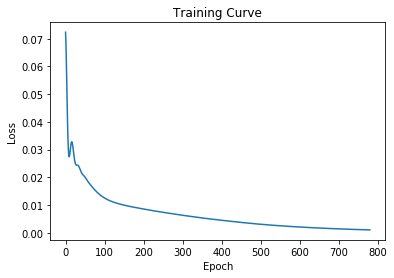

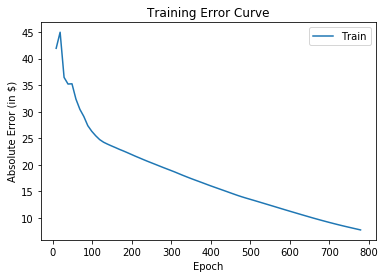

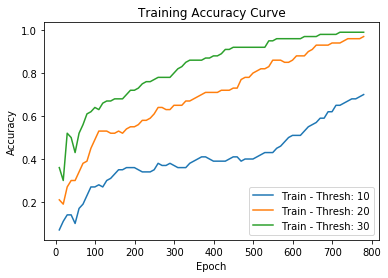

[EPOCH 781] loss: 0.000988  time: 0.094
[EPOCH 782] loss: 0.000984  time: 0.102
[EPOCH 783] loss: 0.000980  time: 0.088
[EPOCH 784] loss: 0.000976  time: 0.126
[EPOCH 785] loss: 0.000972  time: 0.097
[EPOCH 786] loss: 0.000968  time: 0.114
[EPOCH 787] loss: 0.000964  time: 0.098
[EPOCH 788] loss: 0.000960  time: 0.091
[EPOCH 789] loss: 0.000957  time: 0.097
[EPOCH 790] loss: 0.000953  time: 0.332


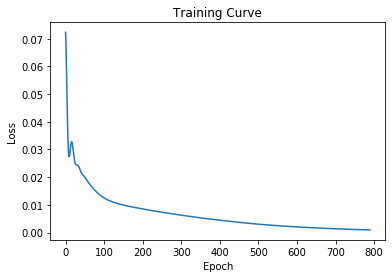

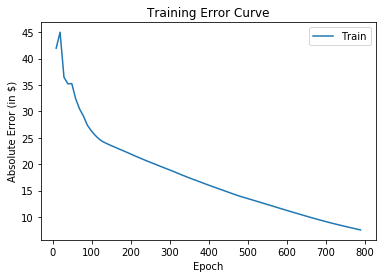

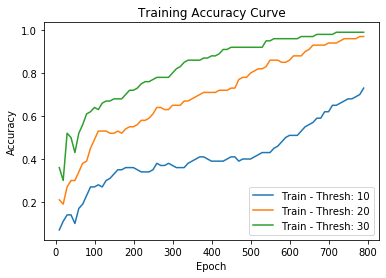

[EPOCH 791] loss: 0.000949  time: 0.076
[EPOCH 792] loss: 0.000945  time: 0.097
[EPOCH 793] loss: 0.000941  time: 0.131
[EPOCH 794] loss: 0.000937  time: 0.099
[EPOCH 795] loss: 0.000934  time: 0.111
[EPOCH 796] loss: 0.000930  time: 0.099
[EPOCH 797] loss: 0.000926  time: 0.101
[EPOCH 798] loss: 0.000922  time: 0.104
[EPOCH 799] loss: 0.000919  time: 0.106
[EPOCH 800] loss: 0.000915  time: 0.337


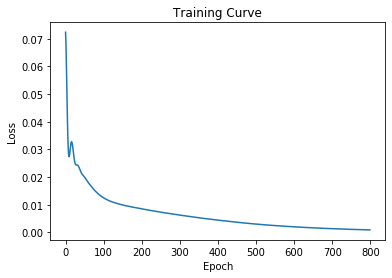

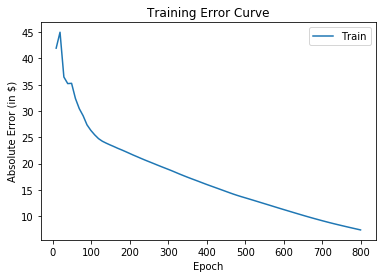

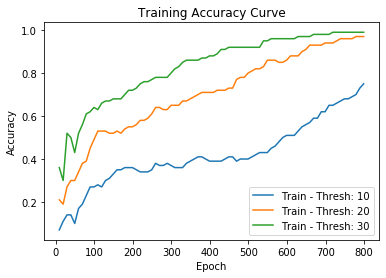

[EPOCH 801] loss: 0.000911  time: 0.077
[EPOCH 802] loss: 0.000908  time: 0.100
[EPOCH 803] loss: 0.000904  time: 0.102
[EPOCH 804] loss: 0.000900  time: 0.110
[EPOCH 805] loss: 0.000897  time: 0.102
[EPOCH 806] loss: 0.000893  time: 0.134
[EPOCH 807] loss: 0.000890  time: 0.095
[EPOCH 808] loss: 0.000886  time: 0.092
[EPOCH 809] loss: 0.000883  time: 0.103
[EPOCH 810] loss: 0.000879  time: 0.332


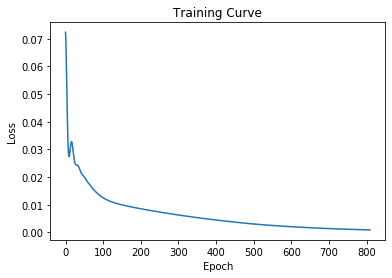

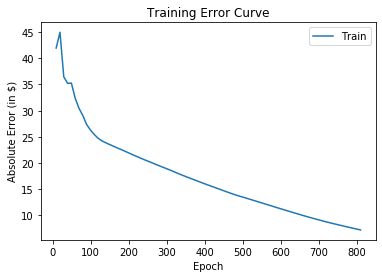

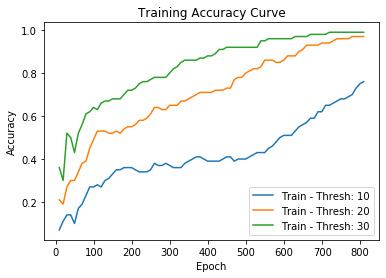

[EPOCH 811] loss: 0.000875  time: 0.086
[EPOCH 812] loss: 0.000872  time: 0.114
[EPOCH 813] loss: 0.000868  time: 0.098
[EPOCH 814] loss: 0.000865  time: 0.118
[EPOCH 815] loss: 0.000862  time: 0.106
[EPOCH 816] loss: 0.000858  time: 0.100
[EPOCH 817] loss: 0.000855  time: 0.093
[EPOCH 818] loss: 0.000851  time: 0.108
[EPOCH 819] loss: 0.000848  time: 0.114
[EPOCH 820] loss: 0.000844  time: 0.300


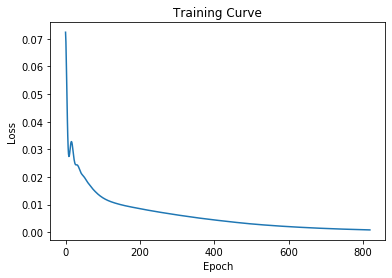

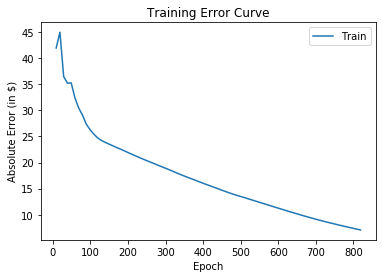

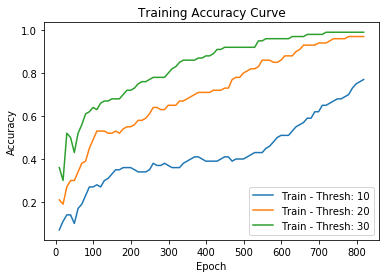

[EPOCH 821] loss: 0.000841  time: 0.095
[EPOCH 822] loss: 0.000837  time: 0.094
[EPOCH 823] loss: 0.000834  time: 0.107
[EPOCH 824] loss: 0.000831  time: 0.102
[EPOCH 825] loss: 0.000827  time: 0.094
[EPOCH 826] loss: 0.000824  time: 0.109
[EPOCH 827] loss: 0.000821  time: 0.095
[EPOCH 828] loss: 0.000817  time: 0.095
[EPOCH 829] loss: 0.000814  time: 0.110
[EPOCH 830] loss: 0.000811  time: 0.289


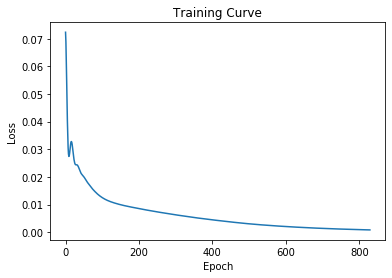

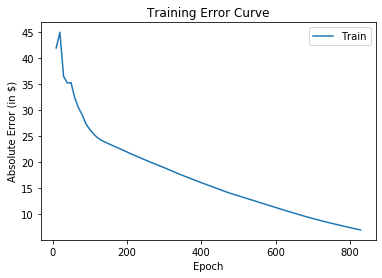

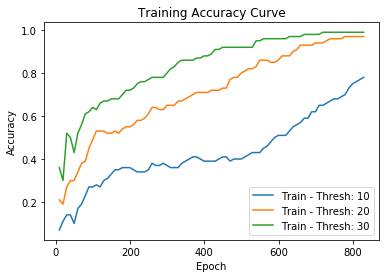

[EPOCH 831] loss: 0.000807  time: 0.080
[EPOCH 832] loss: 0.000804  time: 0.094
[EPOCH 833] loss: 0.000801  time: 0.102
[EPOCH 834] loss: 0.000798  time: 0.104
[EPOCH 835] loss: 0.000794  time: 0.095
[EPOCH 836] loss: 0.000791  time: 0.104
[EPOCH 837] loss: 0.000788  time: 0.100
[EPOCH 838] loss: 0.000785  time: 0.105
[EPOCH 839] loss: 0.000782  time: 0.090
[EPOCH 840] loss: 0.000779  time: 0.305


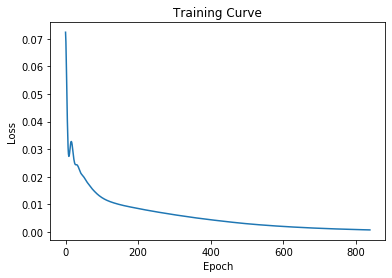

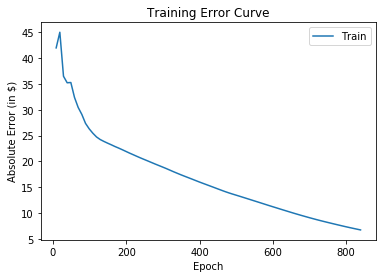

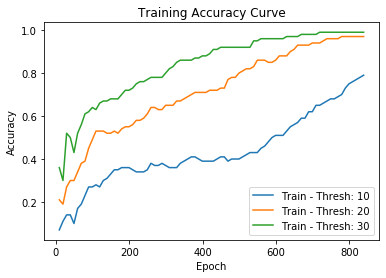

[EPOCH 841] loss: 0.000775  time: 0.081
[EPOCH 842] loss: 0.000772  time: 0.091
[EPOCH 843] loss: 0.000769  time: 0.096
[EPOCH 844] loss: 0.000766  time: 0.104
[EPOCH 845] loss: 0.000763  time: 0.102
[EPOCH 846] loss: 0.000760  time: 0.123
[EPOCH 847] loss: 0.000757  time: 0.103
[EPOCH 848] loss: 0.000754  time: 0.100
[EPOCH 849] loss: 0.000751  time: 0.100
[EPOCH 850] loss: 0.000748  time: 0.286


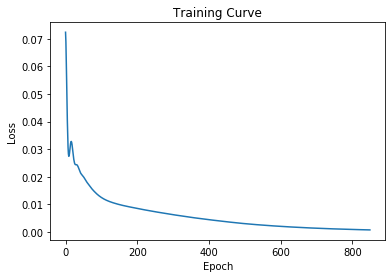

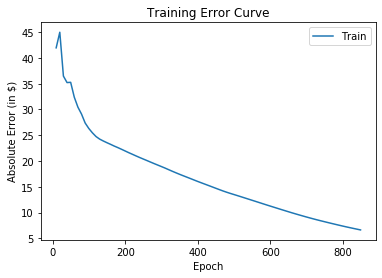

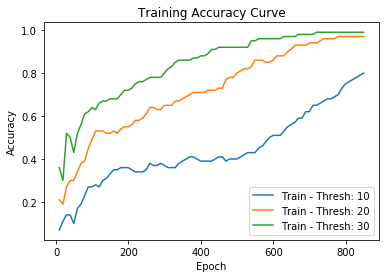

[EPOCH 851] loss: 0.000745  time: 0.092
[EPOCH 852] loss: 0.000742  time: 0.145
[EPOCH 853] loss: 0.000739  time: 0.170
[EPOCH 854] loss: 0.000736  time: 0.123
[EPOCH 855] loss: 0.000733  time: 0.148
[EPOCH 856] loss: 0.000730  time: 0.163
[EPOCH 857] loss: 0.000727  time: 0.159
[EPOCH 858] loss: 0.000724  time: 0.138
[EPOCH 859] loss: 0.000721  time: 0.116
[EPOCH 860] loss: 0.000718  time: 0.329


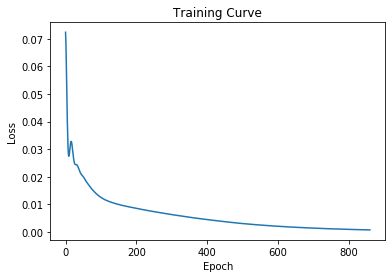

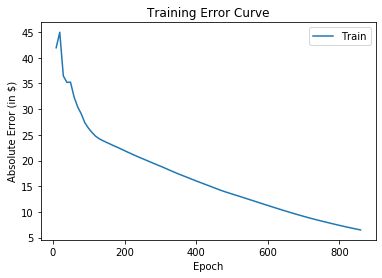

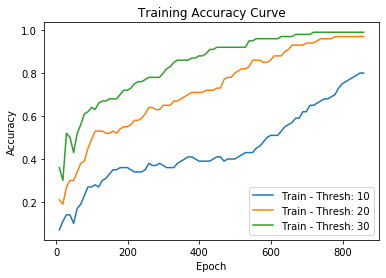

[EPOCH 861] loss: 0.000715  time: 0.113
[EPOCH 862] loss: 0.000712  time: 0.119
[EPOCH 863] loss: 0.000710  time: 0.120
[EPOCH 864] loss: 0.000707  time: 0.130
[EPOCH 865] loss: 0.000704  time: 0.124
[EPOCH 866] loss: 0.000701  time: 0.111
[EPOCH 867] loss: 0.000698  time: 0.116
[EPOCH 868] loss: 0.000695  time: 0.127
[EPOCH 869] loss: 0.000693  time: 0.124
[EPOCH 870] loss: 0.000690  time: 0.380


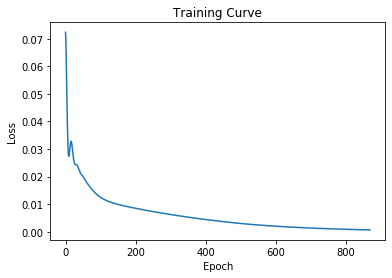

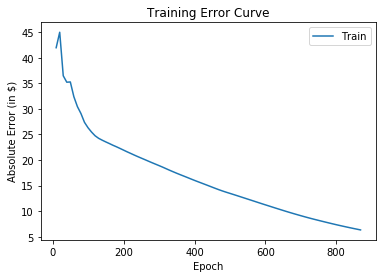

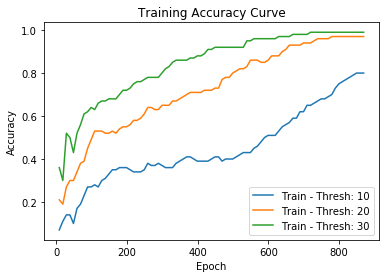

[EPOCH 871] loss: 0.000687  time: 0.095
[EPOCH 872] loss: 0.000684  time: 0.123
[EPOCH 873] loss: 0.000681  time: 0.123
[EPOCH 874] loss: 0.000679  time: 0.127
[EPOCH 875] loss: 0.000676  time: 0.127
[EPOCH 876] loss: 0.000673  time: 0.133
[EPOCH 877] loss: 0.000670  time: 0.131
[EPOCH 878] loss: 0.000668  time: 0.123
[EPOCH 879] loss: 0.000665  time: 0.136
[EPOCH 880] loss: 0.000662  time: 0.365


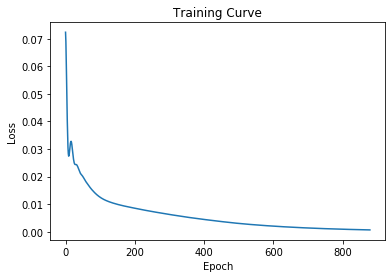

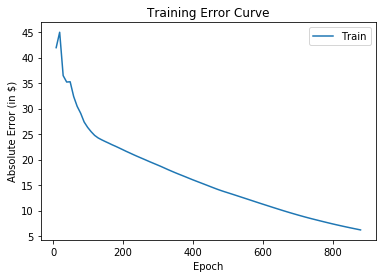

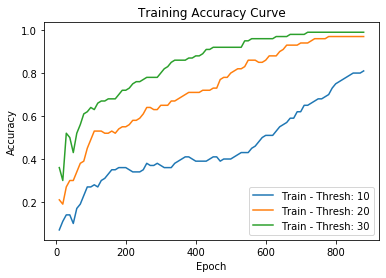

[EPOCH 881] loss: 0.000660  time: 0.097
[EPOCH 882] loss: 0.000657  time: 0.112
[EPOCH 883] loss: 0.000654  time: 0.131
[EPOCH 884] loss: 0.000652  time: 0.119
[EPOCH 885] loss: 0.000649  time: 0.117
[EPOCH 886] loss: 0.000646  time: 0.139
[EPOCH 887] loss: 0.000644  time: 0.124
[EPOCH 888] loss: 0.000641  time: 0.131
[EPOCH 889] loss: 0.000638  time: 0.140
[EPOCH 890] loss: 0.000636  time: 0.345


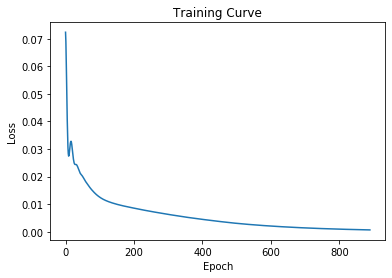

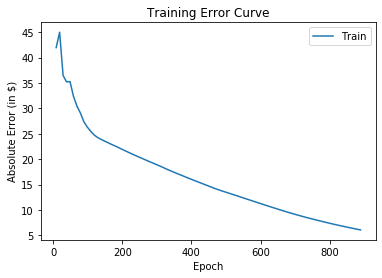

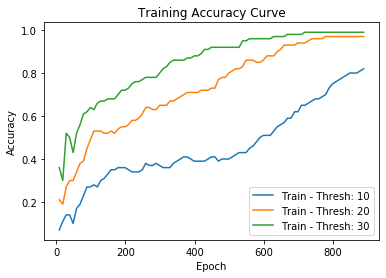

[EPOCH 891] loss: 0.000633  time: 0.097
[EPOCH 892] loss: 0.000630  time: 0.121
[EPOCH 893] loss: 0.000628  time: 0.129
[EPOCH 894] loss: 0.000625  time: 0.109
[EPOCH 895] loss: 0.000623  time: 0.133
[EPOCH 896] loss: 0.000620  time: 0.125
[EPOCH 897] loss: 0.000618  time: 0.123
[EPOCH 898] loss: 0.000615  time: 0.122
[EPOCH 899] loss: 0.000613  time: 0.119
[EPOCH 900] loss: 0.000610  time: 0.327


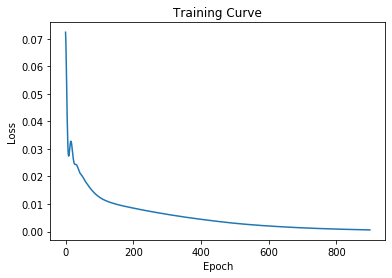

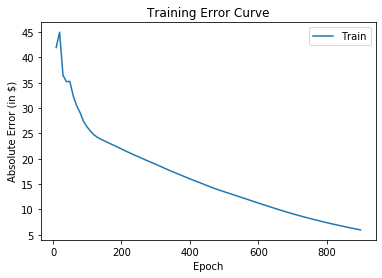

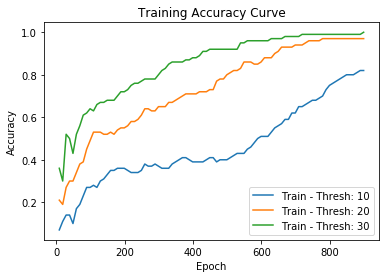

[EPOCH 901] loss: 0.000608  time: 0.097
[EPOCH 902] loss: 0.000605  time: 0.120
[EPOCH 903] loss: 0.000603  time: 0.127
[EPOCH 904] loss: 0.000600  time: 0.103
[EPOCH 905] loss: 0.000598  time: 0.099
[EPOCH 906] loss: 0.000595  time: 0.110
[EPOCH 907] loss: 0.000593  time: 0.120
[EPOCH 908] loss: 0.000591  time: 0.118
[EPOCH 909] loss: 0.000588  time: 0.109
[EPOCH 910] loss: 0.000586  time: 0.343


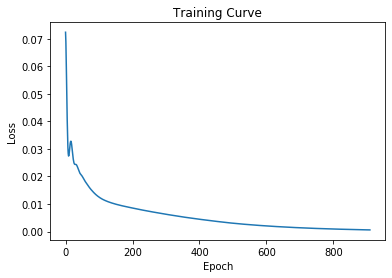

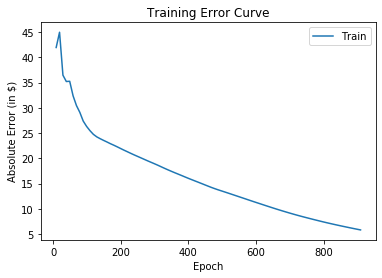

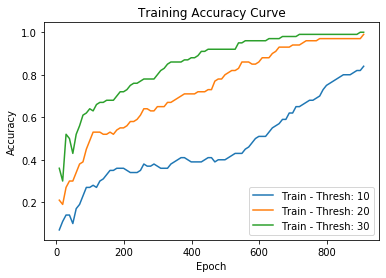

[EPOCH 911] loss: 0.000584  time: 0.094
[EPOCH 912] loss: 0.000581  time: 0.113
[EPOCH 913] loss: 0.000579  time: 0.114
[EPOCH 914] loss: 0.000577  time: 0.123
[EPOCH 915] loss: 0.000574  time: 0.106
[EPOCH 916] loss: 0.000572  time: 0.111
[EPOCH 917] loss: 0.000570  time: 0.132
[EPOCH 918] loss: 0.000567  time: 0.111
[EPOCH 919] loss: 0.000565  time: 0.126
[EPOCH 920] loss: 0.000563  time: 0.359


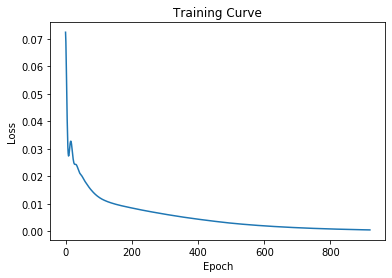

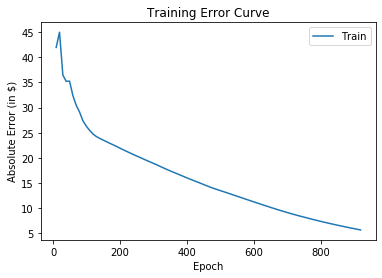

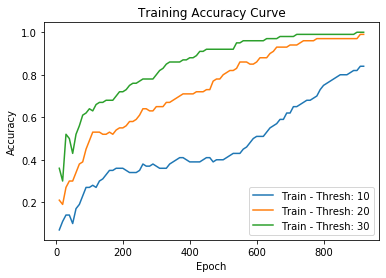

[EPOCH 921] loss: 0.000560  time: 0.099
[EPOCH 922] loss: 0.000558  time: 0.129
[EPOCH 923] loss: 0.000556  time: 0.119
[EPOCH 924] loss: 0.000554  time: 0.114
[EPOCH 925] loss: 0.000552  time: 0.120
[EPOCH 926] loss: 0.000549  time: 0.114
[EPOCH 927] loss: 0.000547  time: 0.117
[EPOCH 928] loss: 0.000545  time: 0.122
[EPOCH 929] loss: 0.000543  time: 0.118
[EPOCH 930] loss: 0.000541  time: 0.353


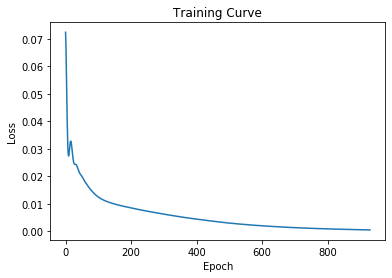

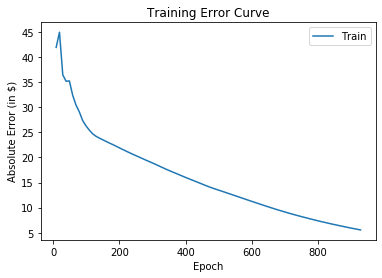

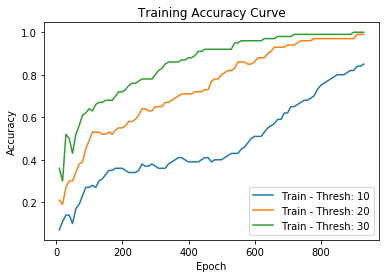

[EPOCH 931] loss: 0.000538  time: 0.092
[EPOCH 932] loss: 0.000536  time: 0.115
[EPOCH 933] loss: 0.000534  time: 0.128
[EPOCH 934] loss: 0.000532  time: 0.121
[EPOCH 935] loss: 0.000530  time: 0.113
[EPOCH 936] loss: 0.000528  time: 0.109
[EPOCH 937] loss: 0.000526  time: 0.125
[EPOCH 938] loss: 0.000523  time: 0.125
[EPOCH 939] loss: 0.000521  time: 0.110
[EPOCH 940] loss: 0.000519  time: 0.368


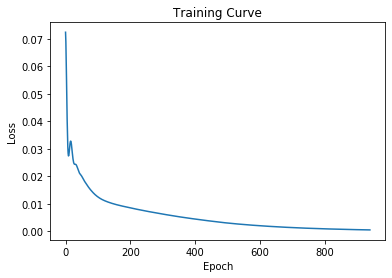

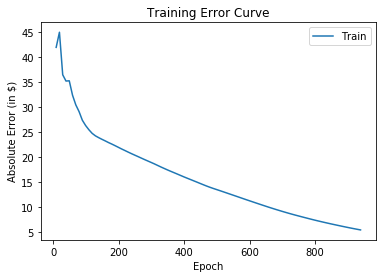

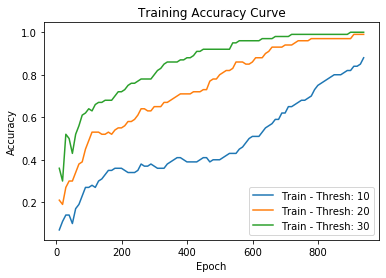

[EPOCH 941] loss: 0.000517  time: 0.079
[EPOCH 942] loss: 0.000515  time: 0.101
[EPOCH 943] loss: 0.000513  time: 0.102
[EPOCH 944] loss: 0.000511  time: 0.105
[EPOCH 945] loss: 0.000509  time: 0.099
[EPOCH 946] loss: 0.000507  time: 0.103
[EPOCH 947] loss: 0.000505  time: 0.102
[EPOCH 948] loss: 0.000503  time: 0.122
[EPOCH 949] loss: 0.000501  time: 0.112
[EPOCH 950] loss: 0.000499  time: 0.322


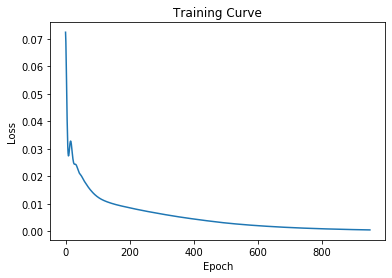

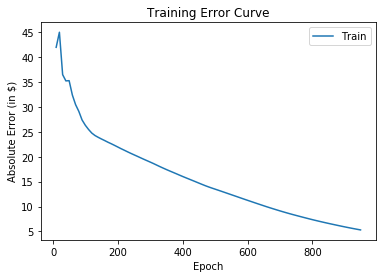

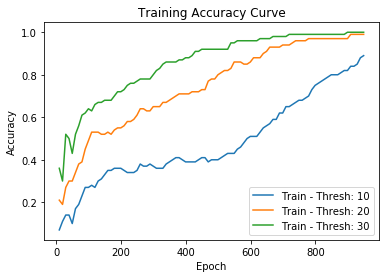

[EPOCH 951] loss: 0.000497  time: 0.095
[EPOCH 952] loss: 0.000495  time: 0.115
[EPOCH 953] loss: 0.000493  time: 0.109
[EPOCH 954] loss: 0.000491  time: 0.121
[EPOCH 955] loss: 0.000489  time: 0.121
[EPOCH 956] loss: 0.000487  time: 0.133
[EPOCH 957] loss: 0.000485  time: 0.145
[EPOCH 958] loss: 0.000483  time: 0.131
[EPOCH 959] loss: 0.000481  time: 0.128
[EPOCH 960] loss: 0.000479  time: 0.369


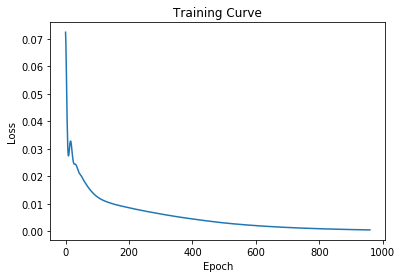

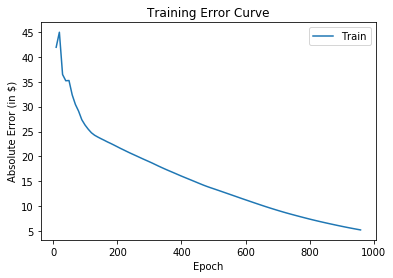

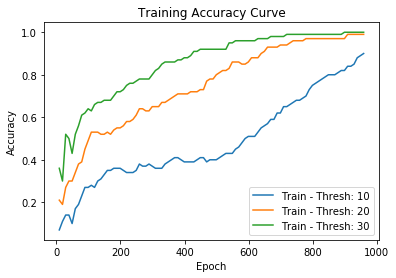

[EPOCH 961] loss: 0.000477  time: 0.077
[EPOCH 962] loss: 0.000475  time: 0.103
[EPOCH 963] loss: 0.000473  time: 0.094
[EPOCH 964] loss: 0.000471  time: 0.104
[EPOCH 965] loss: 0.000469  time: 0.092
[EPOCH 966] loss: 0.000467  time: 0.101
[EPOCH 967] loss: 0.000466  time: 0.100
[EPOCH 968] loss: 0.000464  time: 0.095
[EPOCH 969] loss: 0.000462  time: 0.099
[EPOCH 970] loss: 0.000460  time: 0.283


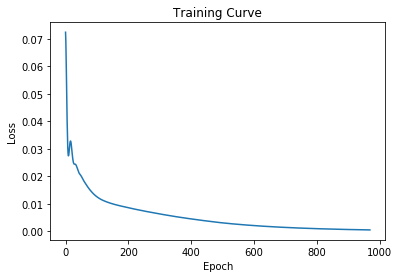

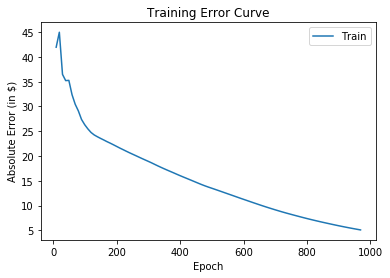

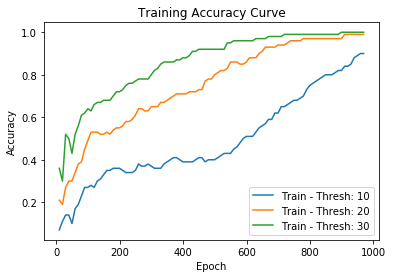

[EPOCH 971] loss: 0.000458  time: 0.091
[EPOCH 972] loss: 0.000456  time: 0.110
[EPOCH 973] loss: 0.000454  time: 0.126
[EPOCH 974] loss: 0.000453  time: 0.134
[EPOCH 975] loss: 0.000451  time: 0.123
[EPOCH 976] loss: 0.000449  time: 0.099
[EPOCH 977] loss: 0.000447  time: 0.095
[EPOCH 978] loss: 0.000445  time: 0.108
[EPOCH 979] loss: 0.000444  time: 0.097
[EPOCH 980] loss: 0.000442  time: 0.332


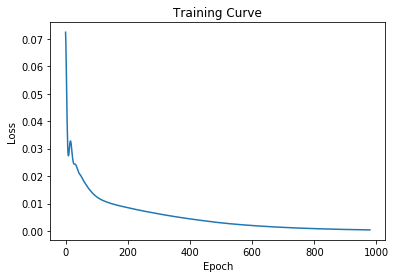

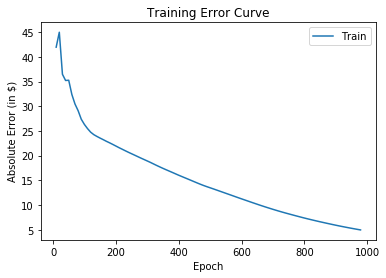

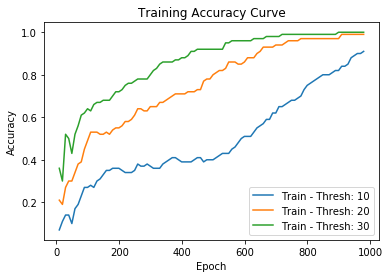

[EPOCH 981] loss: 0.000440  time: 0.183
[EPOCH 982] loss: 0.000438  time: 0.120
[EPOCH 983] loss: 0.000437  time: 0.118
[EPOCH 984] loss: 0.000435  time: 0.112
[EPOCH 985] loss: 0.000433  time: 0.101
[EPOCH 986] loss: 0.000431  time: 0.102
[EPOCH 987] loss: 0.000430  time: 0.101
[EPOCH 988] loss: 0.000428  time: 0.115
[EPOCH 989] loss: 0.000426  time: 0.094
[EPOCH 990] loss: 0.000424  time: 0.305


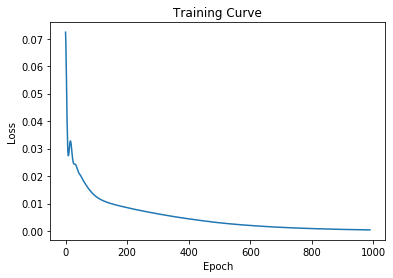

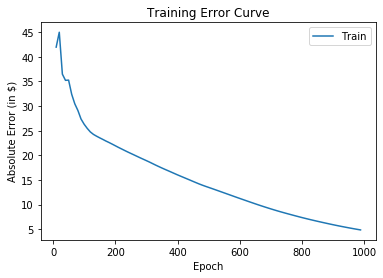

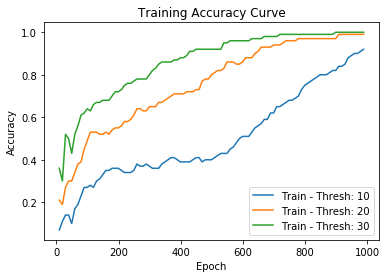

[EPOCH 991] loss: 0.000423  time: 0.090
[EPOCH 992] loss: 0.000421  time: 0.093
[EPOCH 993] loss: 0.000419  time: 0.104
[EPOCH 994] loss: 0.000418  time: 0.109
[EPOCH 995] loss: 0.000416  time: 0.097
[EPOCH 996] loss: 0.000414  time: 0.113
[EPOCH 997] loss: 0.000413  time: 0.104
[EPOCH 998] loss: 0.000411  time: 0.108
[EPOCH 999] loss: 0.000409  time: 0.130
[EPOCH 1000] loss: 0.000408  time: 0.338


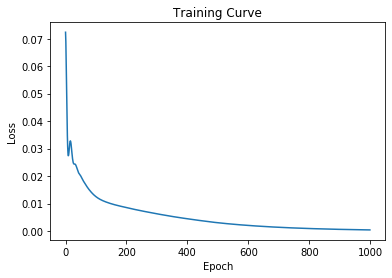

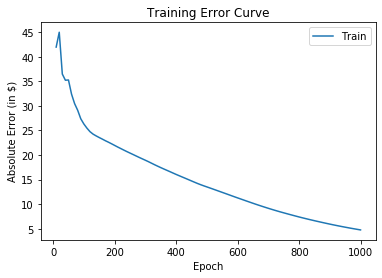

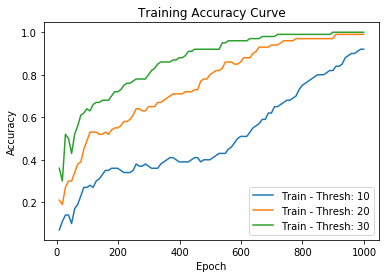

Training Completed...
[FINAL] loss: 0.000408  time: 176.766


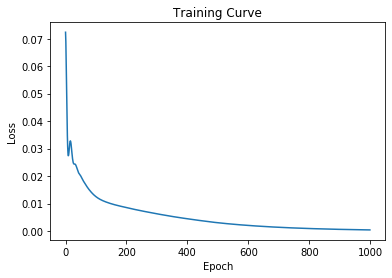

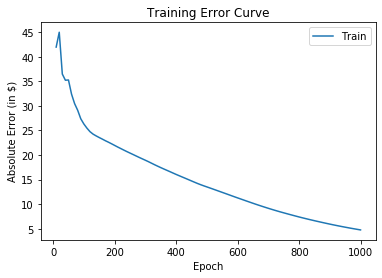

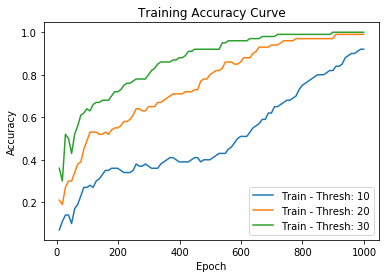

In [92]:
path = os.getcwd() # get current path
path = path[:-5]+"test/Brian/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

train(net, train_loader, val_loader, [minimum, maximum], rootdir)

In [25]:
print(get_error(net, train_loader, val_loader, [10, 20, 30], [min_price, max_price]))

(35.0024061050415, [0.178, 0.345, 0.538], 38.479926016671314, [0.16623376623376623, 0.3425974025974026, 0.5109090909090909])


In [23]:
checkpoint = torch.load("../test/Brian/nov13_test04/final/checkpoint_final.tar")

In [25]:
checkpoint["val_error"]

[34.43894228650378,
 35.83059950196898,
 35.20208893813096,
 35.42489372550667,
 35.10756815724559,
 35.612320750843395,
 35.43602366856166,
 35.75061823262797,
 38.191008970582644,
 36.0117606621284,
 36.27131522636909,
 36.42488970867999,
 37.92559171007825,
 38.63904003985516,
 37.045016219894606,
 39.63381715650682,
 38.47357951771129,
 39.15875888378589,
 39.387500798609345,
 37.906936154055906,
 36.06007952603427,
 37.271799354057805,
 39.78754980508383,
 36.2472255736512,
 37.580929428695086,
 36.794814554189706,
 36.54239235816063,
 36.17199177333287,
 36.63762147581423,
 36.92418649648691,
 36.172215687144885,
 36.490600038999084,
 36.39277947562081,
 36.42565697013558,
 36.38779320654931,
 36.89388121964095,
 36.29964807683771,
 37.54299867704317,
 43.96128279252486,
 37.29611850292652,
 36.174962197836344,
 36.518757355925324,
 36.14648048499962,
 36.283035656817546,
 36.27694470492276,
 36.229664156034396,
 36.638569853151,
 36.03357458139395,
 36.095627859536705,
 38.10048